In [150]:
import shap
import warnings
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy import interpolate
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
np.random.seed(0)
%matplotlib inline

In [151]:
df = pd.read_csv('../data/city_hour.csv', parse_dates = ['Datetime'], low_memory = False)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707875 entries, 0 to 707874
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   City        707875 non-null  object        
 1   Datetime    707875 non-null  datetime64[ns]
 2   PM2.5       562787 non-null  float64       
 3   PM10        411138 non-null  float64       
 4   NO          591243 non-null  float64       
 5   NO2         590753 non-null  float64       
 6   NOx         584651 non-null  float64       
 7   NH3         435333 non-null  float64       
 8   CO          621358 non-null  float64       
 9   SO2         577502 non-null  float64       
 10  O3          578667 non-null  float64       
 11  Benzene     544229 non-null  float64       
 12  Toluene     487268 non-null  float64       
 13  Xylene      252046 non-null  float64       
 14  AQI         578795 non-null  float64       
 15  AQI_Bucket  578795 non-null  object        
dtypes:

In [153]:
# Set the display format for float values
pd.options.display.float_format = '{:.2f}'.format

In [154]:
df.describe()

Datetime     PM2.5      PM10        NO       NO2  \
count                         707875 562787.00 411138.00 591243.00 590753.00   
mean   2018-05-14 02:41:03.445098752     67.62    119.08     17.42     28.89   
min              2015-01-01 01:00:00      0.01      0.01      0.01      0.01   
25%              2017-04-15 23:00:00     26.20     52.38      3.84     10.81   
50%              2018-08-04 20:00:00     46.42     91.50      7.96     20.32   
75%              2019-09-02 14:00:00     79.49    147.52     16.15     36.35   
max              2020-07-01 00:00:00    999.99   1000.00    499.99    499.51   
std                              NaN     74.73    104.22     32.10     29.16   

            NOx       NH3        CO       SO2        O3   Benzene   Toluene  \
count 584651.00 435333.00 621358.00 577502.00 578667.00 544229.00 487268.00   
mean      32.29     23.61      2.18     14.04     34.80      3.09      8.66   
min        0.00      0.01      0.00      0.01      0.01      0.00      0.00   
25%       10.66      8.12      0.42      4.88     13.42      0.05      0.37   
50%       20.79     15.38      0.80      8.37     26.24      0.86      2.59   
75%       37.15     29.23      1.37     14.78     47.62      2.75      8.41   
max      498.61    499.97    498.57    199.96    497.62    498.07    499.40   
std       39.76     28.83     10.97     19.31     29.81     16.46     21.74   

         Xylene       AQI  
count 252046.00 578795.00  
mean       3.13    166.41  
min        0.00      8.00  
25%        0.10     79.00  
50%        0.79    116.00  
75%        3.12    208.00  
max      499.99   3133.00  
std        7.83    162.11

In [155]:
df.head()

City            Datetime  PM2.5  PM10   NO   NO2   NOx  NH3   CO  \
0  Ahmedabad 2015-01-01 01:00:00    NaN   NaN 1.00 40.01 36.37  NaN 1.00   
1  Ahmedabad 2015-01-01 02:00:00    NaN   NaN 0.02 27.75 19.73  NaN 0.02   
2  Ahmedabad 2015-01-01 03:00:00    NaN   NaN 0.08 19.32 11.08  NaN 0.08   
3  Ahmedabad 2015-01-01 04:00:00    NaN   NaN 0.30 16.45  9.20  NaN 0.30   
4  Ahmedabad 2015-01-01 05:00:00    NaN   NaN 0.12 14.90  7.85  NaN 0.12   

     SO2     O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0 122.07    NaN     0.00     0.00    0.00  NaN        NaN  
1  85.90    NaN     0.00     0.00    0.00  NaN        NaN  
2  52.83    NaN     0.00     0.00    0.00  NaN        NaN  
3  39.53 153.58     0.00     0.00    0.00  NaN        NaN  
4  32.63    NaN     0.00     0.00    0.00  NaN        NaN

### **Missing values**

In [156]:
df["Date"] = df.Datetime.dt.date.astype(str)
df.Datetime = df.Datetime.astype(str)

In [157]:
df["PM10"] = df.groupby("City")["PM10"].rolling(window = 24, min_periods = 16).mean().values
df["PM2.5"] = df.groupby("City")["PM2.5"].rolling(window = 24, min_periods = 16).mean().values
df["SO2"] = df.groupby("City")["SO2"].rolling(window = 24, min_periods = 16).mean().values
df["CO"] = df.groupby("City")["CO"].rolling(window = 8, min_periods = 1).max().values
df["O3"] = df.groupby("City")["O3"].rolling(window = 8, min_periods = 1).max().values
df["NO2"] = df.groupby("City")["O3"].rolling(window = 24, min_periods = 1).max().values

In [158]:
round(df.isna().sum()/len(df) * 100, 2)

City          0.00
Datetime      0.00
PM2.5        21.07
PM10         42.24
NO           16.48
NO2          13.22
NOx          17.41
NH3          38.50
CO            9.03
SO2          18.76
O3           15.73
Benzene      23.12
Toluene      31.16
Xylene       64.39
AQI          18.23
AQI_Bucket   18.23
Date          0.00
dtype: float64

### **AQI_Bucket category count**

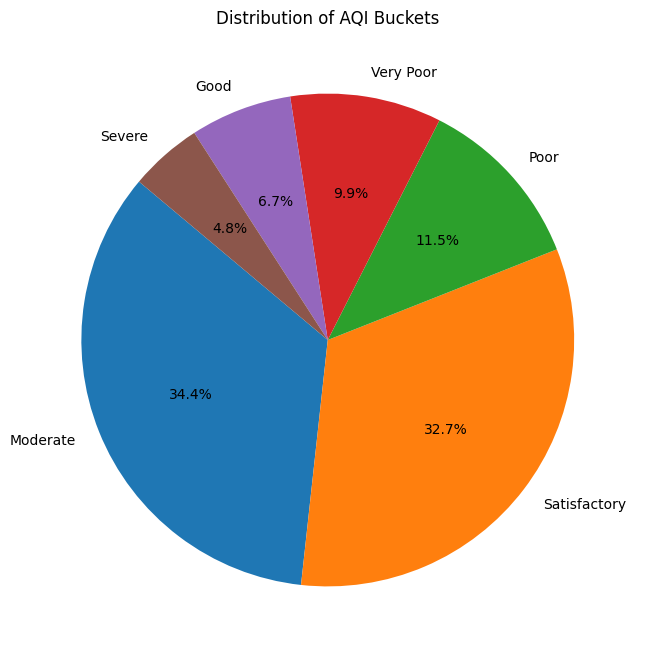

In [159]:
aqi_bucket_percentages = (df['AQI_Bucket'].value_counts() / len(df)) * 100
plt.figure(figsize=(8, 8))
plt.pie(aqi_bucket_percentages, labels=aqi_bucket_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of AQI Buckets')
plt.show()

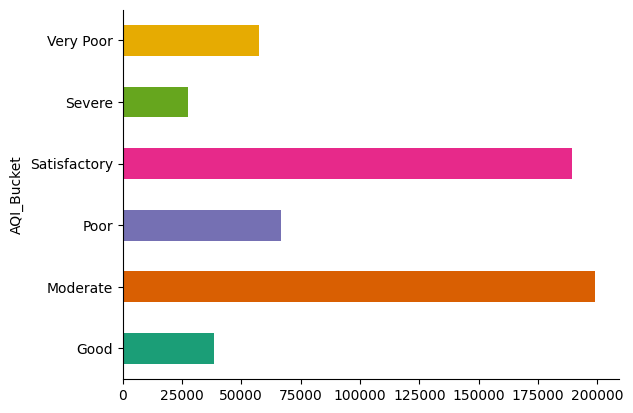

In [160]:
df.groupby('AQI_Bucket').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

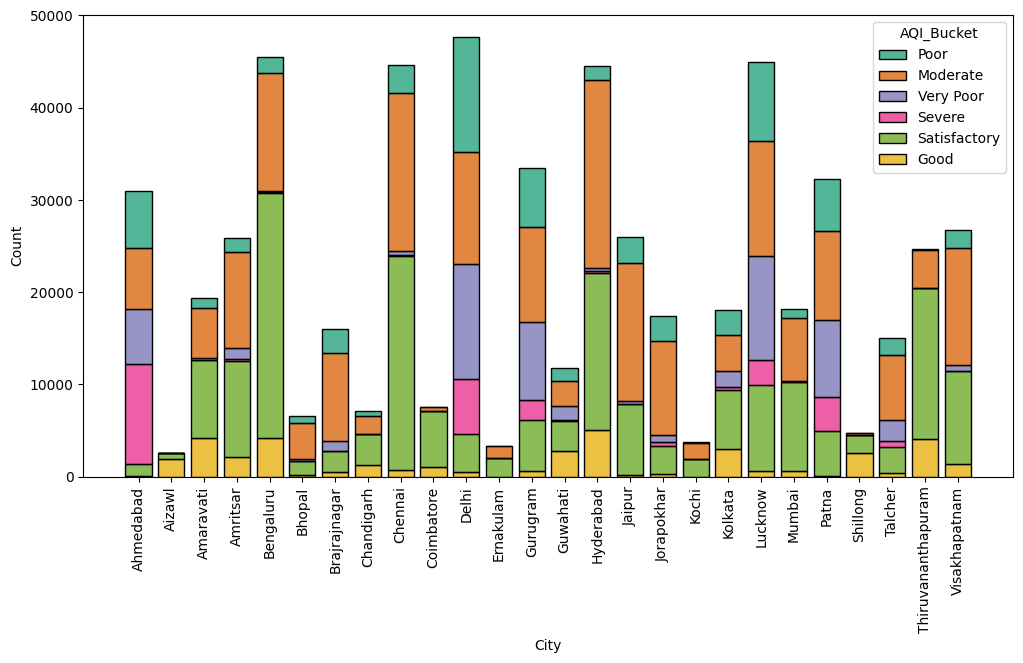

In [161]:
#AQI_Bucket with respect to cities
plt.figure(figsize=(12,6))
sns.histplot(data=df,x='City',hue='AQI_Bucket',palette='Dark2',multiple='stack',shrink=0.8)
plt.xticks(rotation=90)
plt.show()

In [162]:
def pair_plot(df):
  sns.pairplot(df, diag_kind="kde", markers="+",
                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))

In [163]:
# pair_plot(df)

In [164]:
def column_density(df, columns):
    n_rows = len(columns)
    fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(10, 10))

    for i, col in enumerate(columns):
        sns.kdeplot(data=df, x=col,color='red', fill=True, ax=axes[i])

    plt.tight_layout()
    plt.show()


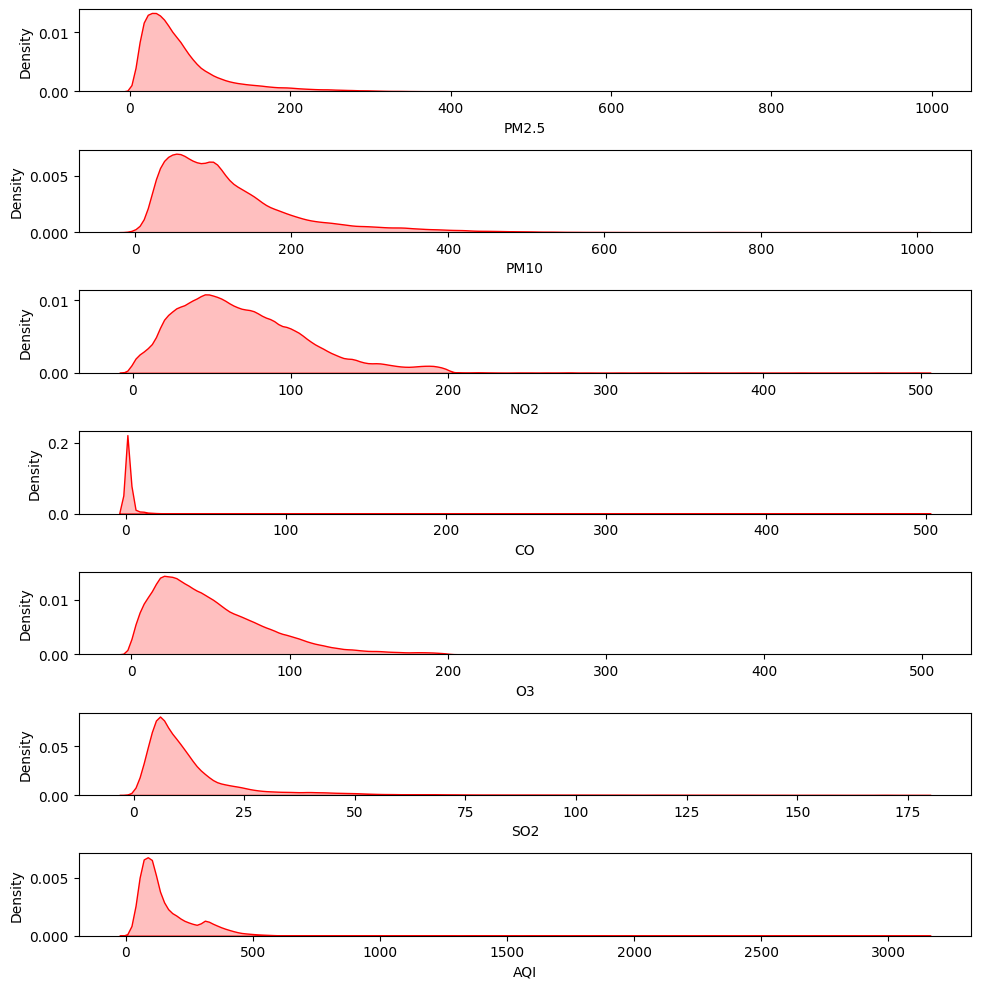

In [165]:
col = ['PM2.5','PM10','NO2','CO','O3','SO2','AQI']
column_density(df,col)

In [166]:
def outlier_detection(df,columns):
    n_rows = len(columns)
    fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(10, 25))

    for i, col in enumerate(columns):
        sns.boxplot(data=df,x='AQI_Bucket',y=col,palette='Dark2', fill=True, ax=axes[i])
    plt.show()


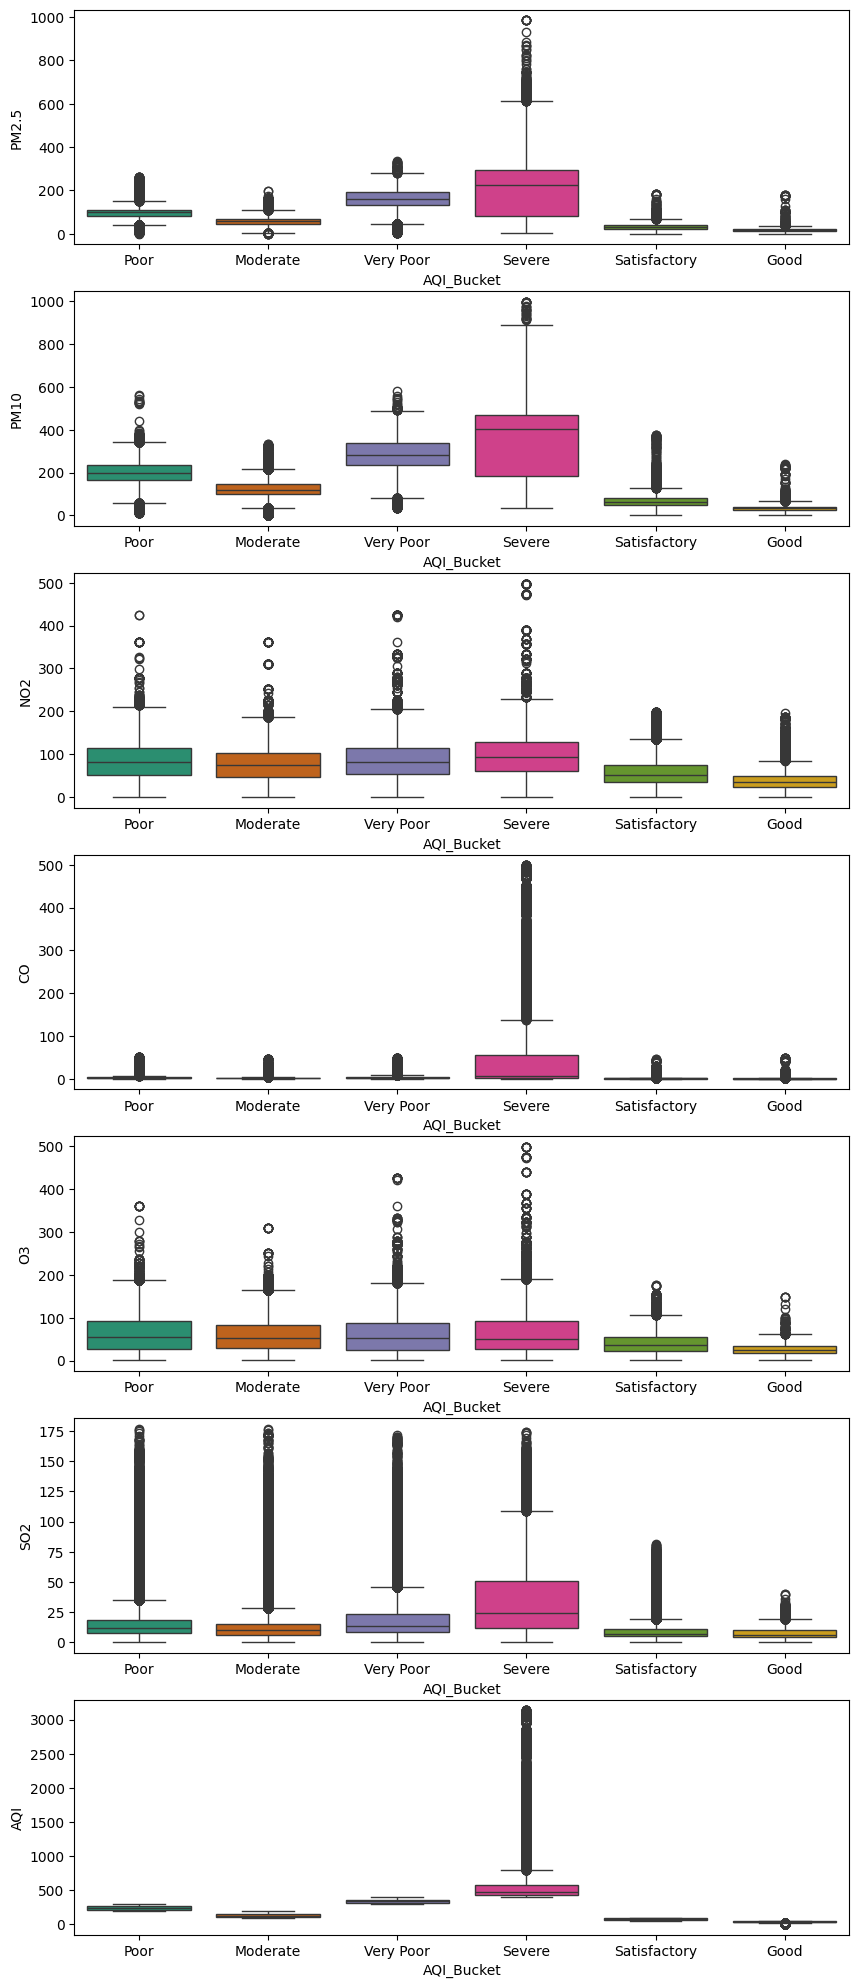

In [167]:
col = ['PM2.5','PM10','NO2','CO','O3','SO2','AQI']
outlier_detection(df,col)

### **Filling missing values**

In [168]:
df.isna().sum()

City               0
Datetime           0
PM2.5         149176
PM10          299022
NO            116632
NO2            93609
NOx           123224
NH3           272542
CO             63887
SO2           132771
O3            111361
Benzene       163646
Toluene       220607
Xylene        455829
AQI           129080
AQI_Bucket    129080
Date               0
dtype: int64

In [169]:
df = df.drop(['NO', 'NOx', 'NH3', 'Benzene', 'Toluene', 'Xylene'] , axis = 1)

### **Correlation matrix**

In [170]:
def plot_corr_matrix(df):
    # Create the correlation matrix
    numeric_columns = df.select_dtypes(include=['float64']).columns
    plt.figure(figsize=(12,6))
    correlation_matrix = df[numeric_columns].corr()

    # Generate a heatmap
    sns.heatmap(correlation_matrix, annot=True)
    plt.show()

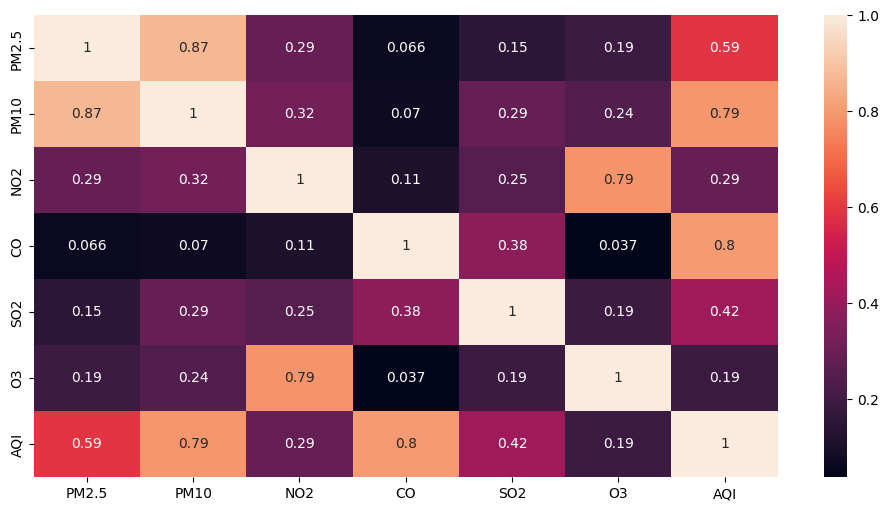

In [171]:
plot_corr_matrix(df)


As we can see in correlation matrix that benzene,toluene and xylene are not contributing so much in predicting AQI.

In [172]:
df.dropna(subset =['AQI_Bucket'], inplace = True)
df.sort_values(by = ['City', 'AQI_Bucket', 'Date'], inplace = True)

In [173]:
df.shape

(578795, 11)

In [174]:
df1 = df.copy()

In [175]:
df1.isna().sum()

City               0
Datetime           0
PM2.5          20716
PM10          170575
NO2            16292
CO             12103
SO2            23965
O3             20597
AQI                0
AQI_Bucket         0
Date               0
dtype: int64

In [176]:
# Exclude columns not suitable for filling missing values
columns_to_exclude = ['Date', 'Datetime', 'City', 'AQI_Bucket', 'AQI']
columns_to_fill = [col for col in df1.columns if col not in columns_to_exclude]

# Fill missing values with group-specific mean values within each group
df1_grouped_mean = df1.groupby('AQI_Bucket')[columns_to_fill].transform(lambda x: x.fillna(x.mean()))

# Update the original DataFrame with filled values
df1[columns_to_fill] = df1_grouped_mean

# Reset the index
df1.reset_index(drop=True, inplace=True)

In [177]:
df1.sort_values(by = ['City', 'AQI_Bucket', 'Datetime'], inplace = True)
df1.head()

City             Datetime  PM2.5  PM10   NO2   CO   SO2   O3   AQI  \
0  Ahmedabad  2015-07-24 04:00:00  30.14 32.85 13.83 0.58 13.30 3.50 50.00   
1  Ahmedabad  2015-07-24 05:00:00  29.27 32.85 13.83 0.58 13.23 3.50 49.00   
2  Ahmedabad  2015-07-24 06:00:00  28.72 32.85 13.83 0.58 12.87 3.50 48.00   
3  Ahmedabad  2015-07-24 07:00:00  28.69 32.85 13.83 0.58 12.66 3.50 48.00   
4  Ahmedabad  2015-07-24 08:00:00  29.67 32.85 13.83 0.58 12.72 3.50 49.00   

  AQI_Bucket        Date  
0       Good  2015-07-24  
1       Good  2015-07-24  
2       Good  2015-07-24  
3       Good  2015-07-24  
4       Good  2015-07-24

In [178]:
# For DataFrame df
df_selection = df[(df['City'] == 'Ahmedabad') & (df['AQI_Bucket'] == 'Moderate')]

# For DataFrame df1
df1_selection = df1[(df1['City'] == 'Ahmedabad') & (df1['AQI_Bucket'] == 'Moderate')]

In [179]:
df_selection.isna().sum()

City             0
Datetime         0
PM2.5           32
PM10          4234
NO2            192
CO              74
SO2            772
O3             406
AQI              0
AQI_Bucket       0
Date             0
dtype: int64

In [180]:
len(df_selection)

6546

In [181]:
df1_selection.isna().sum()

City          0
Datetime      0
PM2.5         0
PM10          0
NO2           0
CO            0
SO2           0
O3            0
AQI           0
AQI_Bucket    0
Date          0
dtype: int64

In [182]:
df1.isna().sum()

City          0
Datetime      0
PM2.5         0
PM10          0
NO2           0
CO            0
SO2           0
O3            0
AQI           0
AQI_Bucket    0
Date          0
dtype: int64

In [183]:
print(df_selection)
print(df1_selection)

            City             Datetime  PM2.5  PM10    NO2   CO   SO2     O3  \
681    Ahmedabad  2015-01-29 10:00:00  84.23   NaN 120.83 2.03 38.26  72.38   
682    Ahmedabad  2015-01-29 11:00:00  84.58   NaN 120.83 2.03 40.35  72.38   
683    Ahmedabad  2015-01-29 12:00:00  84.53   NaN 120.83 2.03 41.32  88.92   
684    Ahmedabad  2015-01-29 13:00:00  83.72   NaN 120.83 2.03 42.05 116.75   
685    Ahmedabad  2015-01-29 14:00:00  82.95   NaN 120.83 2.03 42.55 116.75   
...          ...                  ...    ...   ...    ...  ...   ...    ...   
48187  Ahmedabad  2020-06-30 20:00:00  37.79   NaN 118.68 1.74 15.35 113.22   
48188  Ahmedabad  2020-06-30 21:00:00  38.89   NaN 118.68 1.74 15.69 113.22   
48189  Ahmedabad  2020-06-30 22:00:00  39.23   NaN 118.68 1.74 16.17 113.22   
48190  Ahmedabad  2020-06-30 23:00:00  40.02   NaN 118.68 1.74 16.39 113.22   
48191  Ahmedabad  2020-07-01 00:00:00  40.10   NaN 113.22 1.74 16.26 113.22   

         AQI AQI_Bucket        Date  
681   181.00 

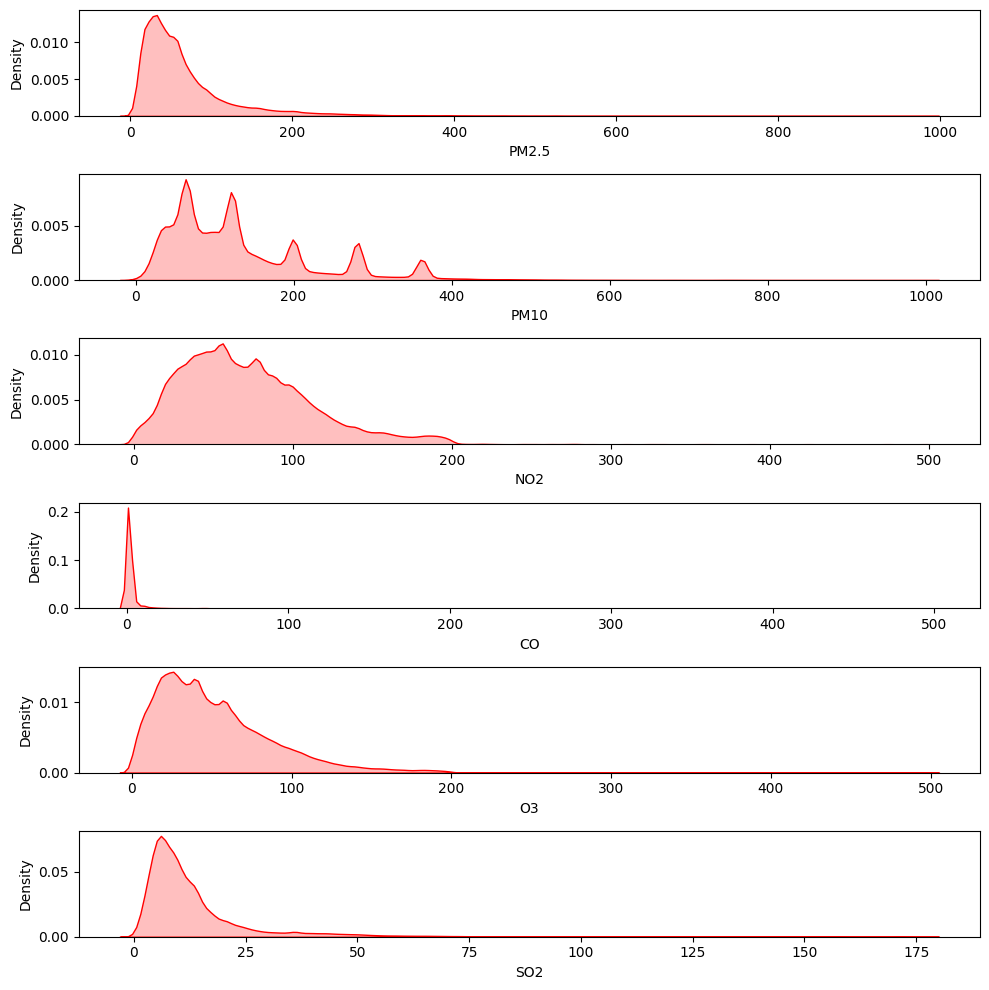

In [184]:
col = ['PM2.5','PM10','NO2','CO','O3','SO2']
column_density(df1,col)

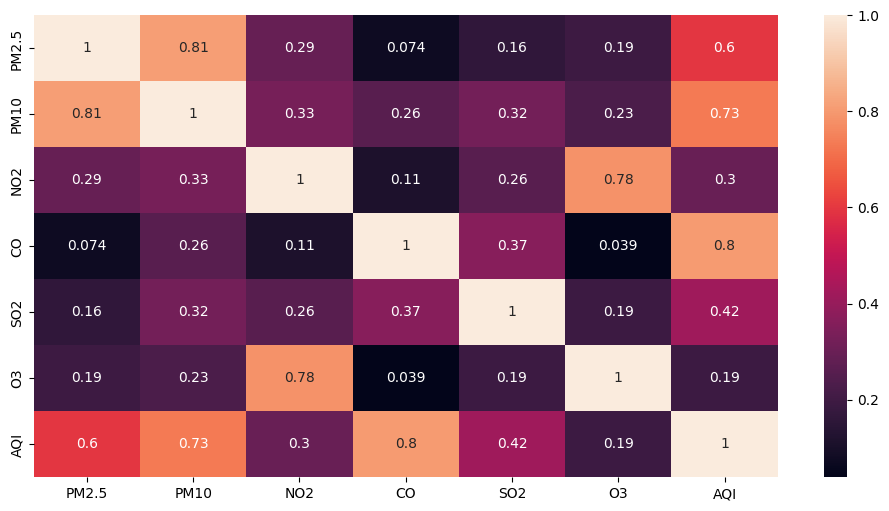

In [185]:
plot_corr_matrix(df1)

In [186]:
# pair_plot(df1)

In [187]:
df1.describe()

PM2.5      PM10       NO2        CO       SO2        O3       AQI
count 578795.00 578795.00 578795.00 578795.00 578795.00 578795.00 578795.00
mean      66.98    133.33     71.06      4.35     14.03     51.36    166.41
std       61.19     95.34     41.44     20.51     15.81     36.36    162.11
min        0.16      0.03      0.01      0.00      0.15      0.01      8.00
25%       29.71     64.00     40.38      0.75      5.90     24.47     79.00
50%       49.47    110.89     64.57      1.21      9.33     43.10    116.00
75%       80.11    179.00     94.52      2.05     15.05     69.62    208.00
max      985.28    996.86    497.62    498.57    176.76    497.62   3133.00

In [188]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578795 entries, 0 to 578794
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        578795 non-null  object 
 1   Datetime    578795 non-null  object 
 2   PM2.5       578795 non-null  float64
 3   PM10        578795 non-null  float64
 4   NO2         578795 non-null  float64
 5   CO          578795 non-null  float64
 6   SO2         578795 non-null  float64
 7   O3          578795 non-null  float64
 8   AQI         578795 non-null  float64
 9   AQI_Bucket  578795 non-null  object 
 10  Date        578795 non-null  object 
dtypes: float64(7), object(4)
memory usage: 48.6+ MB


In [189]:
df1.shape

(578795, 11)

In [190]:
df2 = df1[df1['AQI'] <= 600]

In [191]:
df2.shape

(572526, 11)

In [192]:
df2.describe()

PM2.5      PM10       NO2        CO       SO2        O3       AQI
count 572526.00 572526.00 572526.00 572526.00 572526.00 572526.00 572526.00
mean      66.21    130.97     70.65      2.72     13.52     51.23    155.59
std       58.96     92.12     41.13      6.26     14.65     36.20    107.90
min        0.16      0.03      0.01      0.00      0.15      0.01      8.00
25%       29.54     64.00     40.20      0.75      5.87     24.47     78.00
50%       49.11    109.60     64.21      1.20      9.25     43.04    115.00
75%       79.28    174.31     93.78      2.00     14.77     69.47    203.00
max      573.98    763.99    497.62     68.08    176.76    497.62    600.00

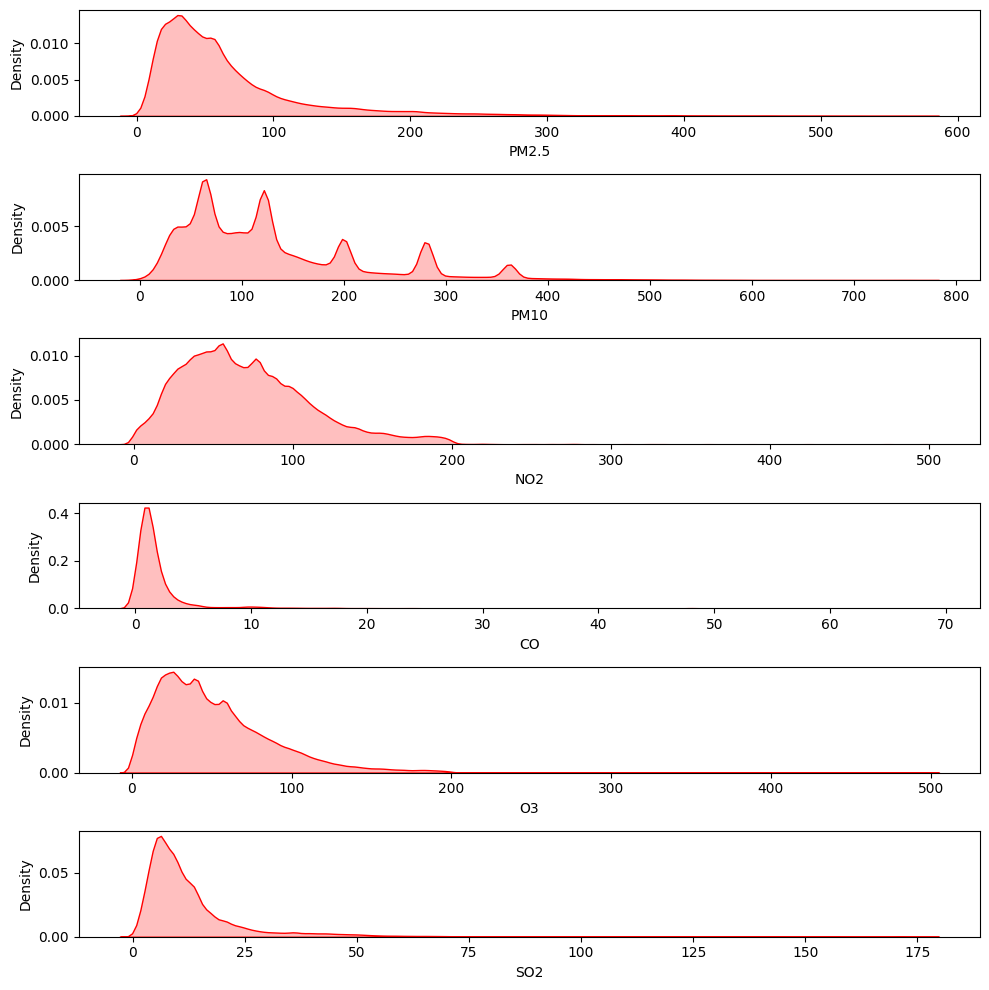

In [193]:
column_density(df2, col)

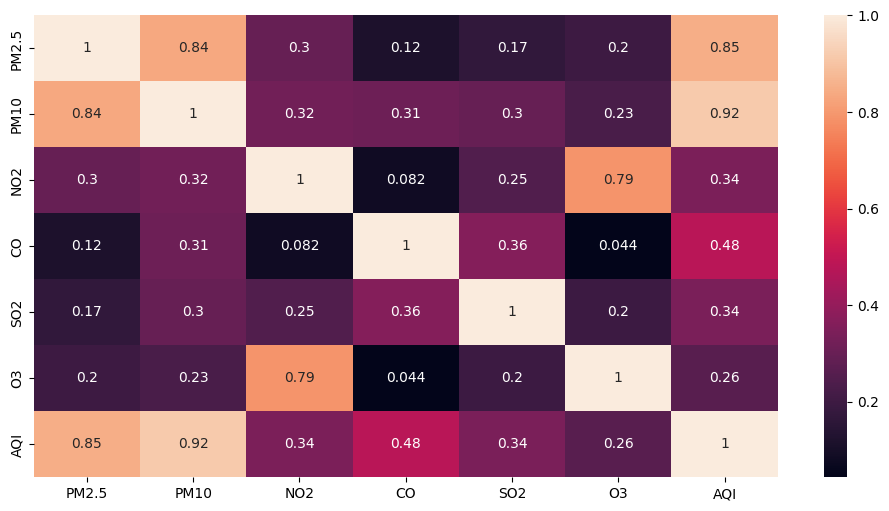

In [194]:
plot_corr_matrix(df2)

In [195]:
df1.to_csv('../data/no_missing.csv', index = False)

# **OUTLIERS DETECT & REMOVE**

In [196]:
df_no_missing = pd.read_csv('../data/no_missing.csv', parse_dates = ['Date'], low_memory = False)

In [197]:
df_no_missing02 = df_no_missing.copy() #data frame where the ouliers will be removed

In [198]:
buckets = df.AQI_Bucket.unique()
columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'SO2', 'O3']
print(buckets)

['Good' 'Moderate' 'Poor' 'Satisfactory' 'Severe' 'Very Poor']


In [199]:
#function for calculating lower and upper bounds for each column using percentiles

def evaluate_limits(df, aqi_bucket, single_column):
    # Get the data for the current aqi_bucket
    data = df[df['AQI_Bucket'] == aqi_bucket]

    lower_percentile = 5
    upper_percentile = 95
    lower_bound = data[single_column].quantile(lower_percentile / 100)
    upper_bound = data[single_column].quantile(upper_percentile / 100)

    return lower_bound, upper_bound

In [200]:
from tabulate import tabulate

def show_limits(df, buckets, columns):
      for aqi_bucket in buckets:
        table_data = []  # List to store table rows

        # Get the data for the current aqi_bucket
        data = df[df['AQI_Bucket'] == aqi_bucket]

        for column in columns:
            # Getting upper and lower bound from calling functions
            lower_bound, upper_bound = evaluate_limits(df, aqi_bucket, column)
            table_data.append([column, lower_bound, upper_bound])

            # Print the table using tabulate with pipe format
        print(f"AQI Bucket: {aqi_bucket}")
        print("-" * 44)
        print(tabulate(table_data, headers=['Column', 'Lower Bound', 'Upper Bound'], tablefmt='pipe'))
        print("-" * 44)
        print()
        print()

In [201]:
#show limits before removal of outliers
columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
buckets = ['Severe', 'Poor','Very Poor', 'Moderate','Satisfactory','Good']
show_limits(df_no_missing, buckets, columns)

AQI Bucket: Severe
--------------------------------------------
| Column   |   Lower Bound |   Upper Bound |
|:---------|--------------:|--------------:|
| PM2.5    |      34.5309  |       421.101 |
| PM10     |     117.428   |       515.425 |
| NO2      |      23.848   |       189.13  |
| CO       |       0.82    |       227.95  |
| O3       |       6.9     |       158.31  |
| SO2      |       4.91997 |       104.763 |
--------------------------------------------


AQI Bucket: Poor
--------------------------------------------
| Column   |   Lower Bound |   Upper Bound |
|:---------|--------------:|--------------:|
| PM2.5    |       35.8743 |      130.502  |
| PM10     |      121.566  |      285.397  |
| NO2      |       19.83   |      181.154  |
| CO       |        0.39   |       15.26   |
| O3       |        8.8865 |      169.014  |
| SO2      |        3.6787 |       53.2267 |
--------------------------------------------


AQI Bucket: Very Poor
--------------------------------------

In [202]:
#print first 3 outliers of some columns

def show_outliers(df, buckets, specific_columns):
    for aqi_bucket in buckets:
        for column in specific_columns:
            lower_bound, upper_bound = evaluate_limits(df, aqi_bucket, column)
            print(f"Column: {column}   AQI Bucket: {aqi_bucket}")
            outliers = df[(df[column] > upper_bound) | (df[column] < lower_bound)].head(3)
            if not outliers.empty:
                # Specify the columns to show the spcific ones
                outliers_filtered = outliers[specific_columns]
                print(outliers_filtered)
            else:
                print("No outliers found.")
            print()
            print()
            print()


specific_columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
buckets = ['Severe', 'Poor','Very Poor', 'Moderate','Satisfactory','Good']
show_outliers(df_no_missing, buckets, specific_columns)


Column: PM2.5   AQI Bucket: Severe
   PM2.5  PM10   NO2   CO   O3   SO2
0  30.14 32.85 13.83 0.58 3.50 13.30
1  29.27 32.85 13.83 0.58 3.50 13.23
2  28.72 32.85 13.83 0.58 3.50 12.87



Column: PM10   AQI Bucket: Severe
   PM2.5  PM10   NO2   CO   O3   SO2
0  30.14 32.85 13.83 0.58 3.50 13.30
1  29.27 32.85 13.83 0.58 3.50 13.23
2  28.72 32.85 13.83 0.58 3.50 12.87



Column: NO2   AQI Bucket: Severe
   PM2.5  PM10   NO2   CO   O3   SO2
0  30.14 32.85 13.83 0.58 3.50 13.30
1  29.27 32.85 13.83 0.58 3.50 13.23
2  28.72 32.85 13.83 0.58 3.50 12.87



Column: CO   AQI Bucket: Severe
   PM2.5  PM10   NO2   CO   O3   SO2
0  30.14 32.85 13.83 0.58 3.50 13.30
1  29.27 32.85 13.83 0.58 3.50 13.23
2  28.72 32.85 13.83 0.58 3.50 12.87



Column: O3   AQI Bucket: Severe
   PM2.5  PM10   NO2   CO   O3   SO2
0  30.14 32.85 13.83 0.58 3.50 13.30
1  29.27 32.85 13.83 0.58 3.50 13.23
2  28.72 32.85 13.83 0.58 3.50 12.87



Column: SO2   AQI Bucket: Severe
     PM2.5   PM10   NO2   CO    O3    SO2
341 

In [203]:
def replace_outliers(df, buckets, columns):
    for aqi_bucket in buckets:
        # Get the data for the current label
        data = df[df['AQI_Bucket'] == aqi_bucket]

        # getting lower and upper bounds for each column by calling predefined function
        for column in columns:
            lower_bound, upper_bound = evaluate_limits(df, aqi_bucket, column)

            # Find the outlier indices
            outlier_indices = data[((data[column] > upper_bound) | (data[column] < lower_bound))].index

            # Replace outliers with the mean
            df.loc[outlier_indices, column] = data[column].mean()
    return df


In [204]:
buckets = ['Severe', 'Poor','Very Poor', 'Moderate','Satisfactory','Good']
columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']

#removinf the outliers from dataframe df_no_missing02
df_no_missing02 = replace_outliers(df_no_missing02, buckets, columns)

In [205]:
#print limits after removal of outliers
columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
buckets = ['Severe', 'Poor','Very Poor', 'Moderate','Satisfactory','Good']
show_limits(df_no_missing02, buckets, columns)

AQI Bucket: Severe
--------------------------------------------
| Column   |   Lower Bound |   Upper Bound |
|:---------|--------------:|--------------:|
| PM2.5    |      43.4772  |      362.385  |
| PM10     |     185.424   |      467.248  |
| NO2      |      37.22    |      166.95   |
| CO       |       1.37    |      130.82   |
| O3       |      11.979   |      130.42   |
| SO2      |       6.81727 |       82.4235 |
--------------------------------------------


AQI Bucket: Poor
--------------------------------------------
| Column   |   Lower Bound |   Upper Bound |
|:---------|--------------:|--------------:|
| PM2.5    |      51.5193  |      120.817  |
| PM10     |     150.596   |      256.897  |
| NO2      |      29.35    |      157.51   |
| CO       |       0.68    |       11.7835 |
| O3       |      14.05    |      129.237  |
| SO2      |       4.98444 |       37.7682 |
--------------------------------------------


AQI Bucket: Very Poor
--------------------------------------

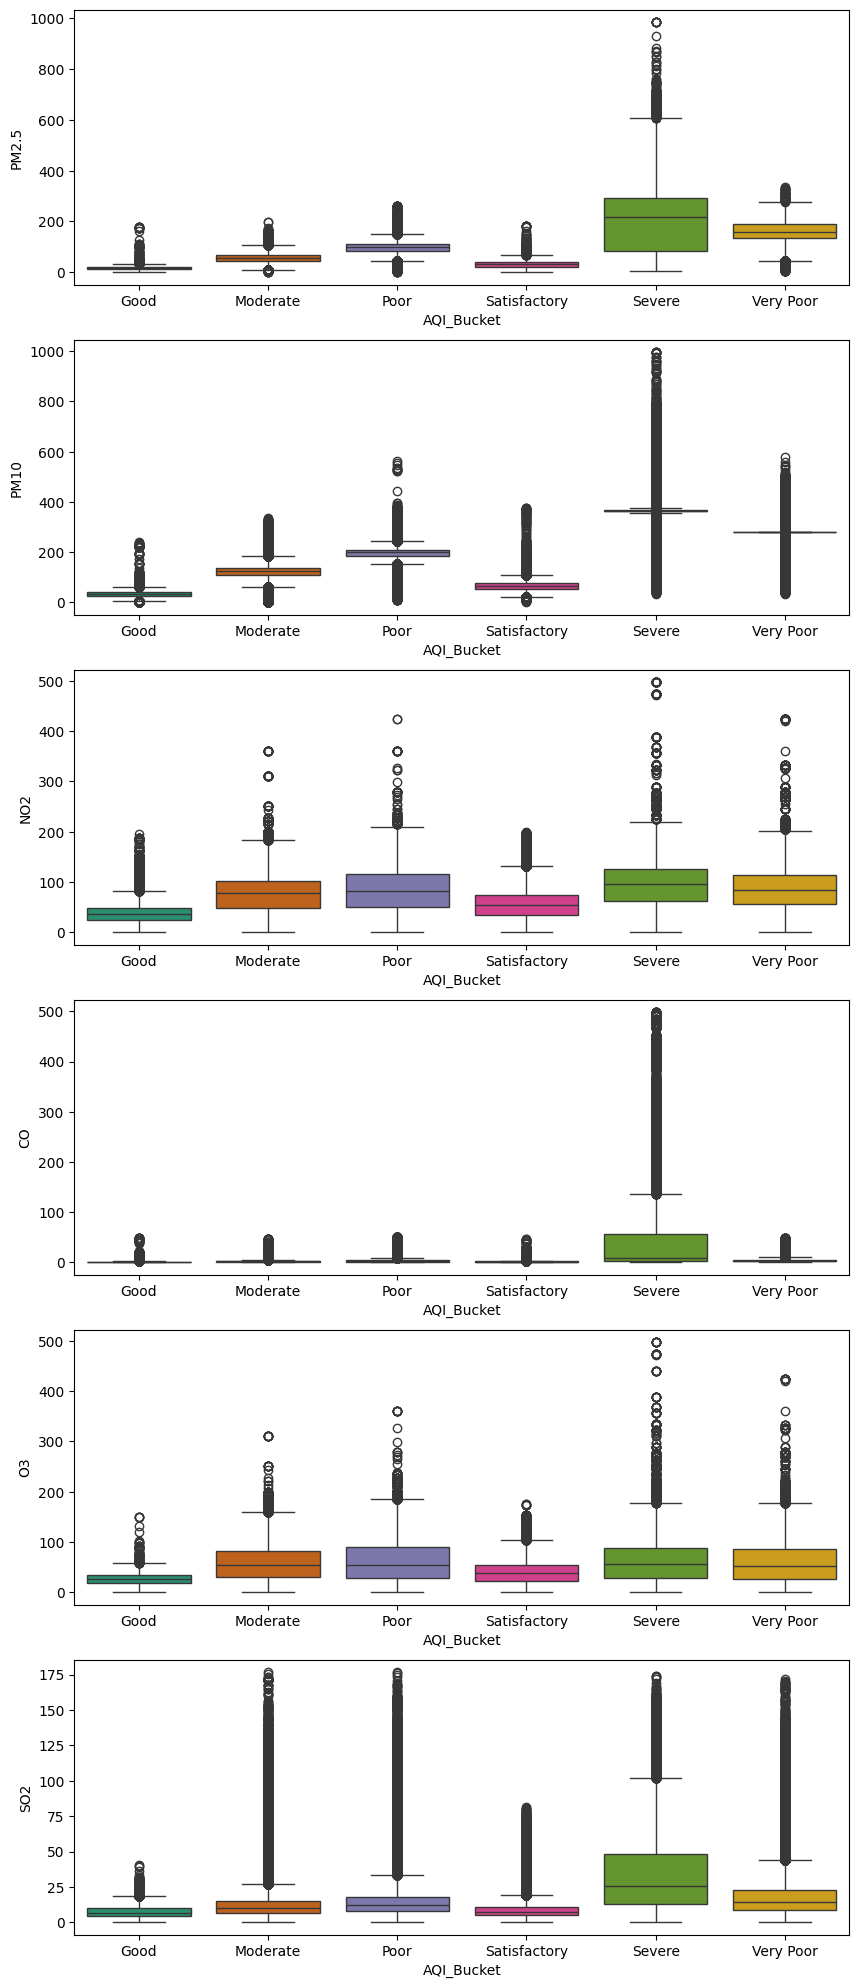

In [206]:
#boxplot before removal of outliers
outlier_detection(df_no_missing, columns)

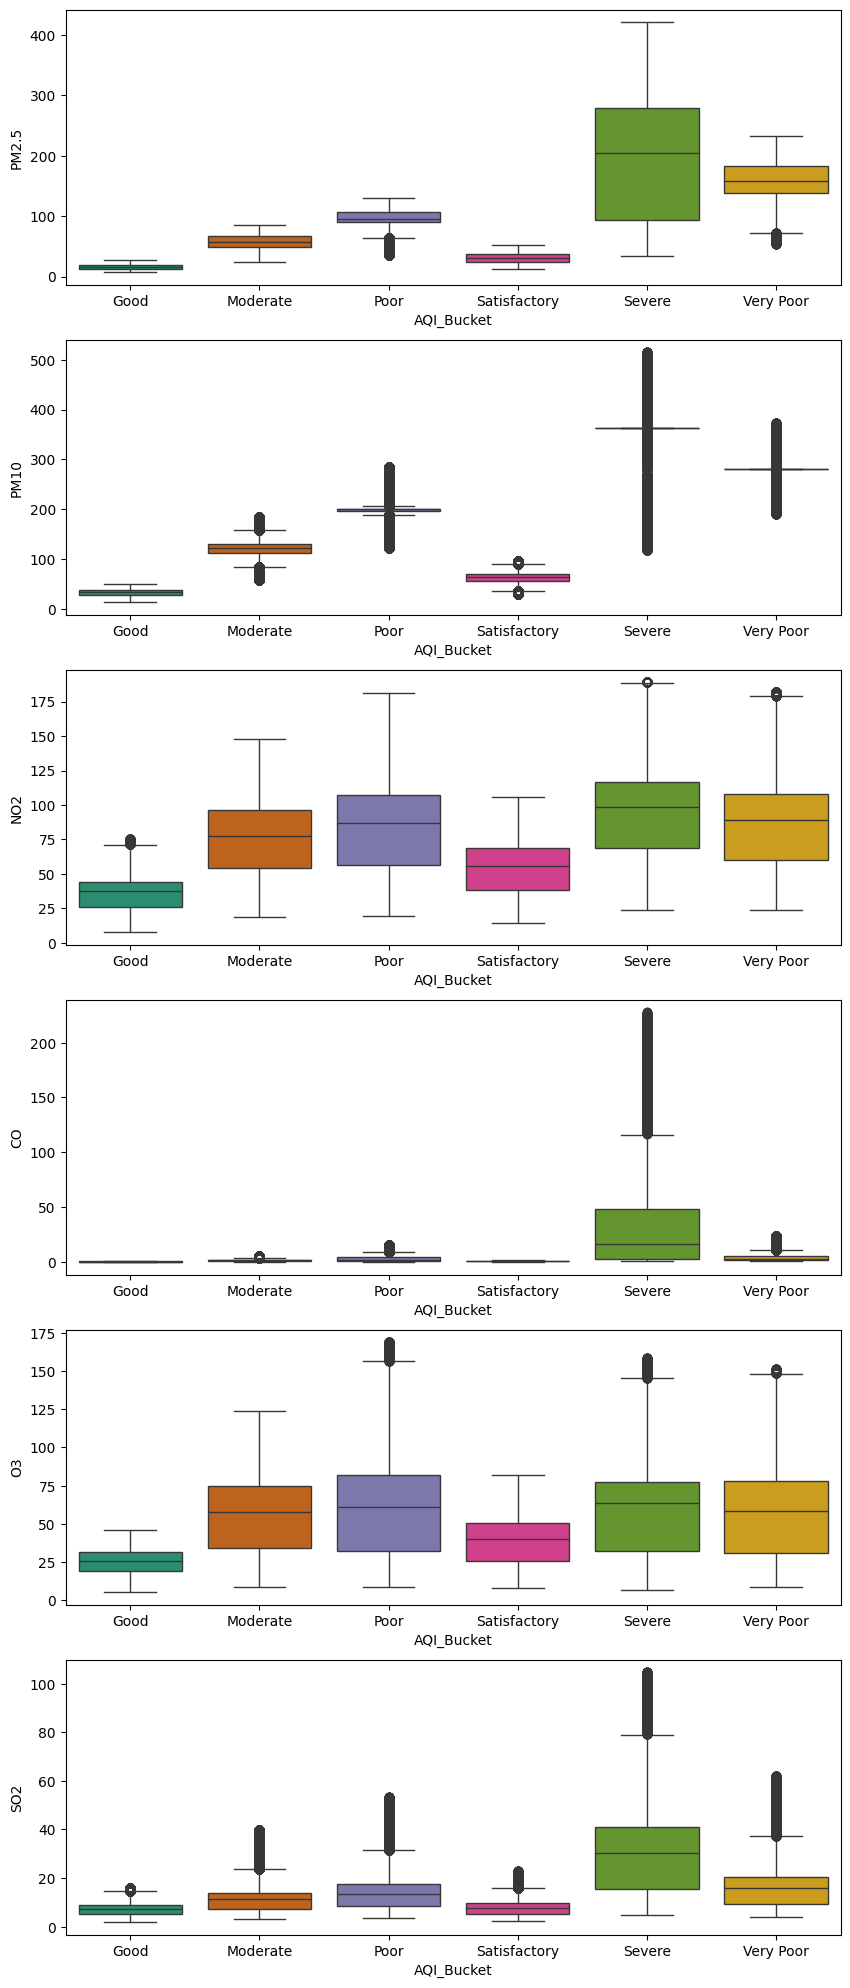

In [207]:
#boxplot after removal of outliers
outlier_detection(df_no_missing02, columns)

In [208]:
df_no_missing.describe()

PM2.5      PM10       NO2        CO       SO2        O3       AQI  \
count 578795.00 578795.00 578795.00 578795.00 578795.00 578795.00 578795.00   
mean      66.98    133.33     71.06      4.35     14.03     51.36    166.41   
min        0.16      0.03      0.01      0.00      0.15      0.01      8.00   
25%       29.71     64.00     40.38      0.75      5.90     24.47     79.00   
50%       49.47    110.89     64.57      1.21      9.34     43.10    116.00   
75%       80.11    179.00     94.52      2.05     15.05     69.62    208.00   
max      985.28    996.86    497.62    498.57    176.76    497.62   3133.00   
std       61.19     95.34     41.44     20.51     15.81     36.36    162.11   

                                Date  
count                         578795  
mean   2018-07-26 22:34:37.904612352  
min              2015-01-01 00:00:00  
25%              2017-08-24 00:00:00  
50%              2018-11-08 00:00:00  
75%              2019-10-11 00:00:00  
max              2020-07-01 00:00:00  
std                              NaN

In [209]:
df_no_missing02.describe()

PM2.5      PM10       NO2        CO       SO2        O3       AQI  \
count 578795.00 578795.00 578795.00 578795.00 578795.00 578795.00 578795.00   
mean      66.94    133.39     69.61      3.48     12.47     49.73    166.41   
min        7.37     13.30      7.86      0.00      1.88      5.26      8.00   
25%       31.28     64.00     44.70      0.83      6.49     27.25     79.00   
50%       50.79    117.64     65.70      1.24      9.52     44.00    116.00   
75%       79.24    175.13     89.40      1.96     14.14     64.59    208.00   
max      420.99    515.40    189.13    227.84    104.75    169.00   3133.00   
std       56.17     90.33     32.65     12.28     10.05     28.40    162.11   

                                Date  
count                         578795  
mean   2018-07-26 22:34:37.904612352  
min              2015-01-01 00:00:00  
25%              2017-08-24 00:00:00  
50%              2018-11-08 00:00:00  
75%              2019-10-11 00:00:00  
max              2020-07-01 00:00:00  
std                              NaN

In [210]:
df_no_missing02.isna().sum()

City          0
Datetime      0
PM2.5         0
PM10          0
NO2           0
CO            0
SO2           0
O3            0
AQI           0
AQI_Bucket    0
Date          0
dtype: int64

Normal Boxplot beore removal of Outliers



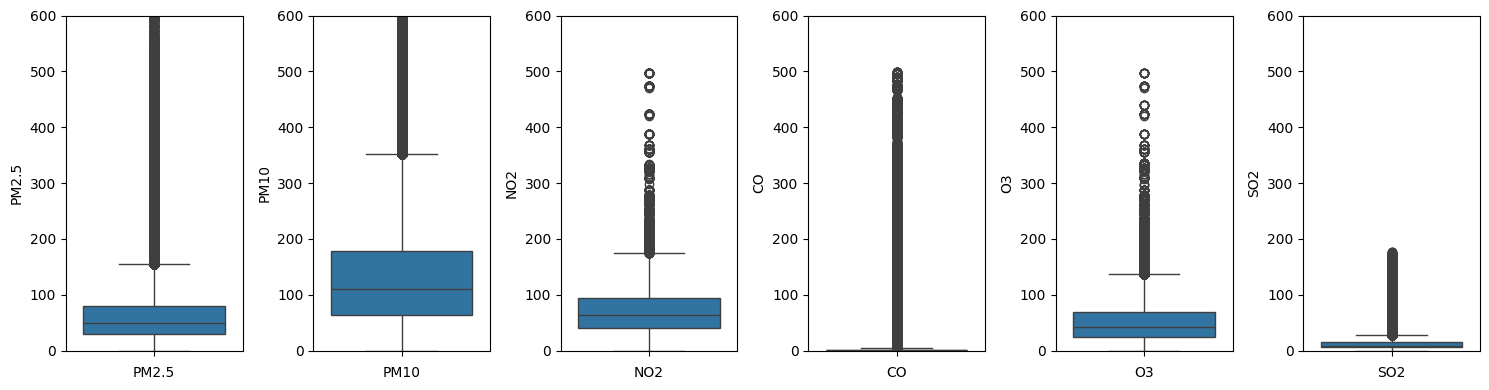




Normal Boxplot after removal of Outliers



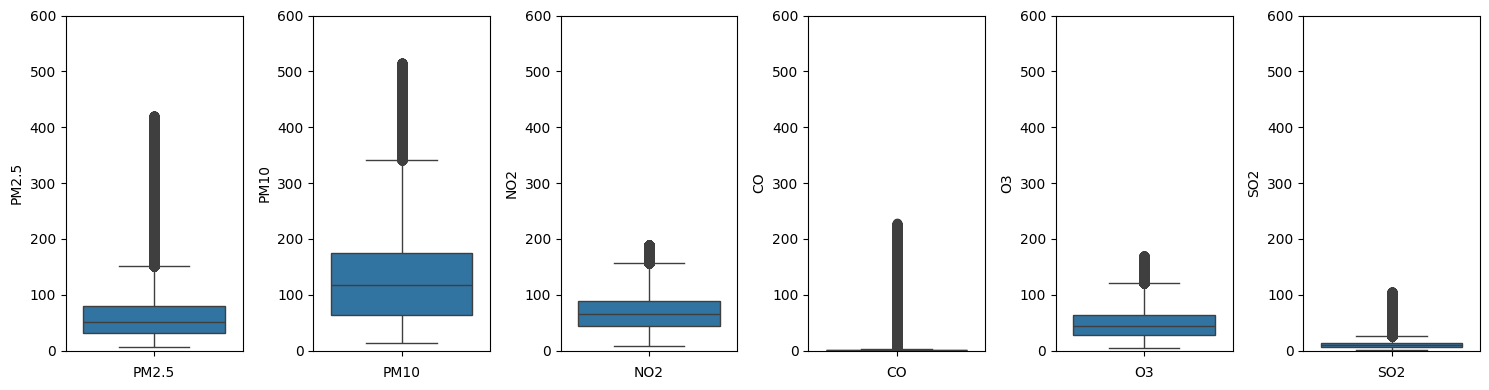

In [211]:
#plotting without AQI_BUCKET for visualizing the whole data
def boxplt(df, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(15, 4))  # Adjust figsize as needed
    for idx, col in enumerate(columns):
        sns.boxplot(y=df[col], ax=axes[idx])
        axes[idx].set_xlabel(col)
        axes[idx].set_ylim(0, 600)  # Set the y-axis range from 0 to 300
    plt.tight_layout()
    plt.show()

columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
print("Normal Boxplot beore removal of Outliers")
print()
boxplt(df_no_missing, columns)
print("\n\n")
print("Normal Boxplot after removal of Outliers")
print()
boxplt(df_no_missing02 , columns)

Correlation matrix before removal of outliers



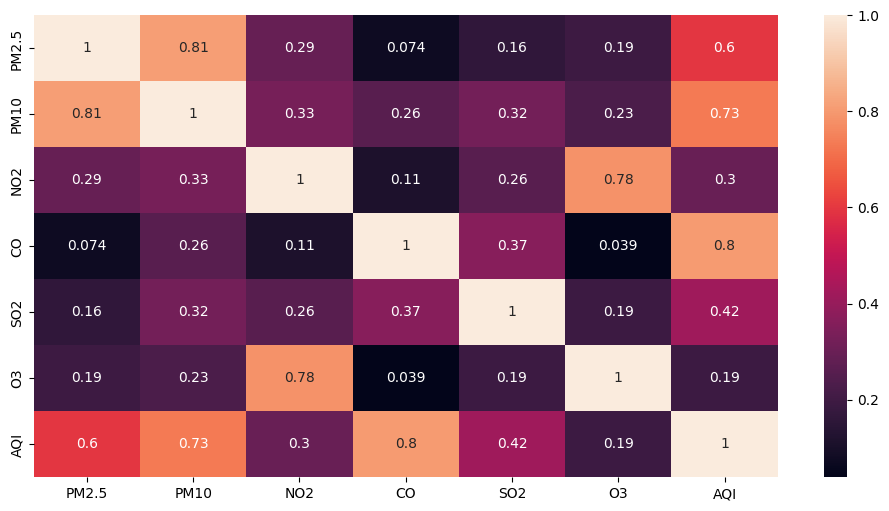

In [212]:
  # Create the correlation matrix
print("Correlation matrix before removal of outliers")
print()
plot_corr_matrix(df_no_missing)

Correlation matrix before removal of outliers



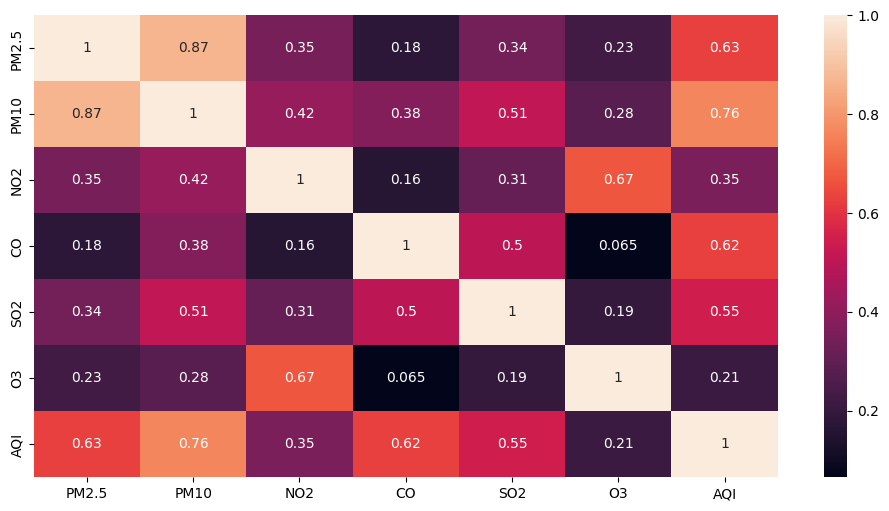

In [213]:
# Create the correlation matrix
print("Correlation matrix before removal of outliers")
print()
plot_corr_matrix(df_no_missing02)

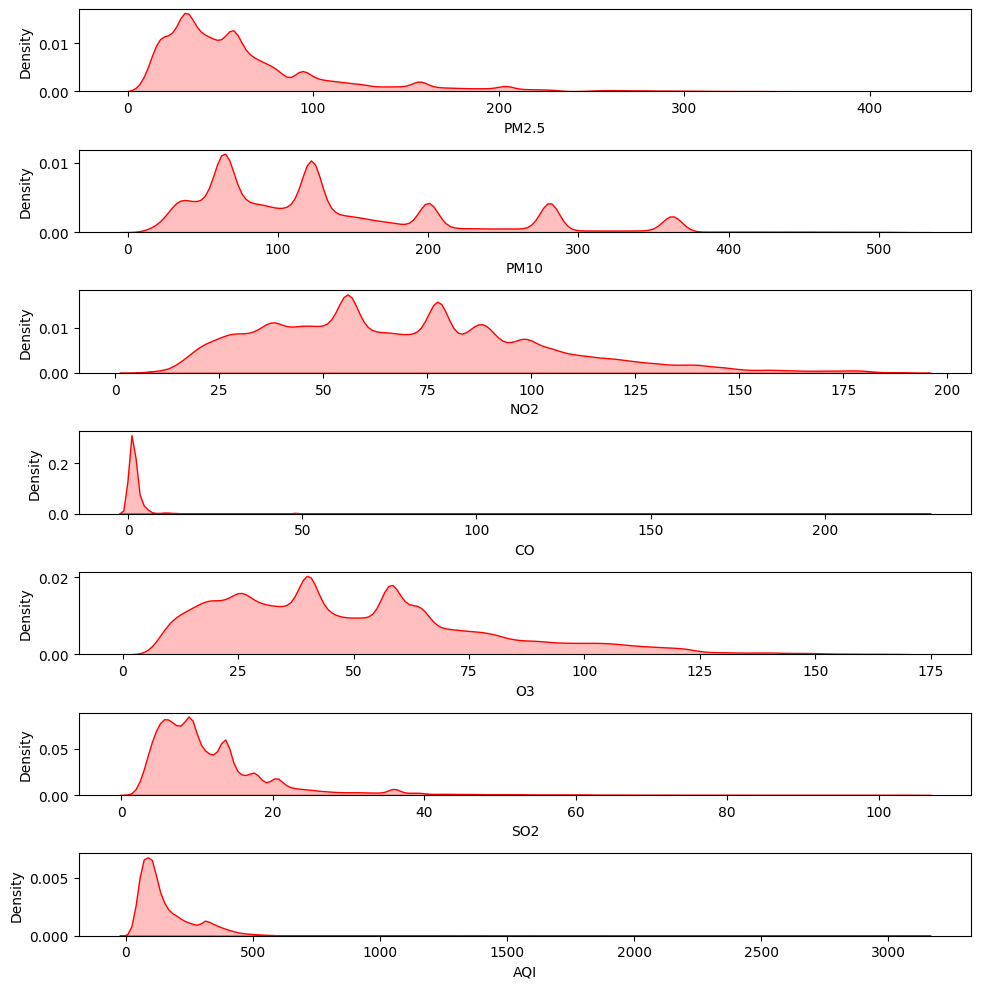

In [214]:
col = ['PM2.5','PM10','NO2','CO','O3','SO2','AQI']
column_density(df_no_missing02,col)

In [215]:
# pair_plot(df_no_missing02)

In [216]:
df_no_missing02.to_csv('../data/clean_data.csv', index = False)

In [217]:
df_no_missing02.isna().sum()

City          0
Datetime      0
PM2.5         0
PM10          0
NO2           0
CO            0
SO2           0
O3            0
AQI           0
AQI_Bucket    0
Date          0
dtype: int64

# Feature Engineering

In [218]:
from sklearn.covariance import EllipticEnvelope

# Read the clean data into a DataFrame
df_clean = pd.read_csv('../data/clean_data.csv', low_memory=False)

# Extract other columns as DataFrame
other_cols = df_clean[['City', 'Datetime', 'AQI_Bucket']]

# Extract features (X) and target variable (y) as NumPy arrays
X = df_clean[['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']].values
y = df_clean['AQI'].values

# Initialize Elliptic Envelope model
elliptic_envelope = EllipticEnvelope(contamination=0.10)  # Adjust contamination parameter as needed

# Fit the model to the data
elliptic_envelope.fit(np.column_stack((X, y)))

# Predict outliers
outlier_predictions = elliptic_envelope.predict(np.column_stack((X, y)))

# Identify outliers
outliers_indices = np.where(outlier_predictions == -1)[0]

# Remove outliers from X, y, and other_cols
X_filtered = np.delete(X, outliers_indices, axis=0)
y_filtered = np.delete(y, outliers_indices)
other_cols_filtered = other_cols.drop(outliers_indices)

# Now X_filtered, y_filtered, and other_cols_filtered contain the dataset with outliers removed
# Create DataFrame from X_filtered and y_filtered
df_filtered = pd.DataFrame(X_filtered, columns=['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3'])
df_filtered['AQI'] = y_filtered

# Reset index of other_cols_filtered and concatenate with df_filtered
df_filtered = pd.concat([df_filtered, other_cols_filtered.reset_index(drop=True)], axis=1)

In [219]:
df_filtered.isna().sum()

PM2.5         0
PM10          0
NO2           0
CO            0
SO2           0
O3            0
AQI           0
City          0
Datetime      0
AQI_Bucket    0
dtype: int64

In [220]:
print(len(df_filtered))
print(len(other_cols))

520915
578795


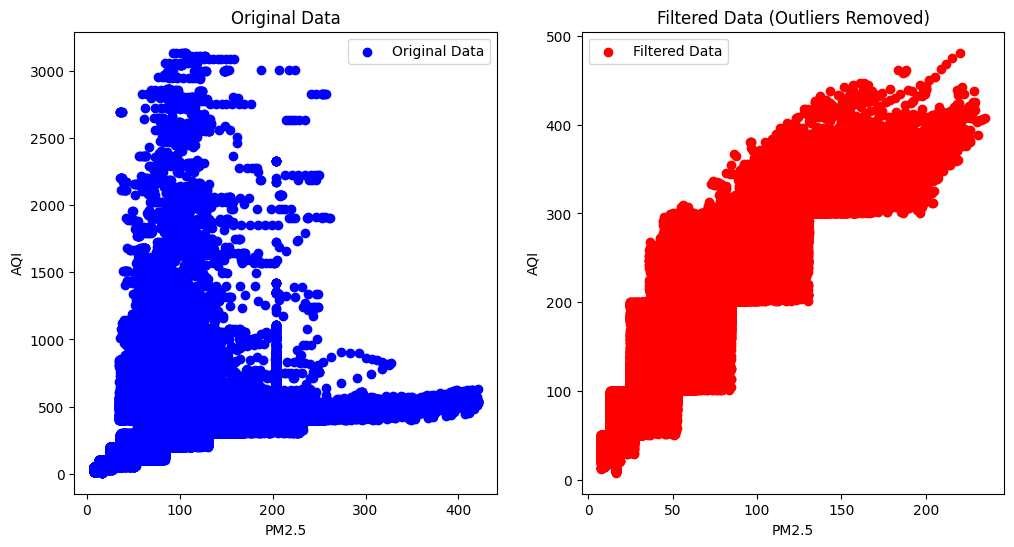

In [221]:
# Create scatter plot of original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], y, color='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('PM2.5')
plt.ylabel('AQI')
plt.legend()

# Create scatter plot of filtered data
plt.subplot(1, 2, 2)
plt.scatter(X_filtered[:, 0], y_filtered, color='red', label='Filtered Data')
plt.title('Filtered Data (Outliers Removed)')
plt.xlabel('PM2.5')
plt.ylabel('AQI')
plt.legend()

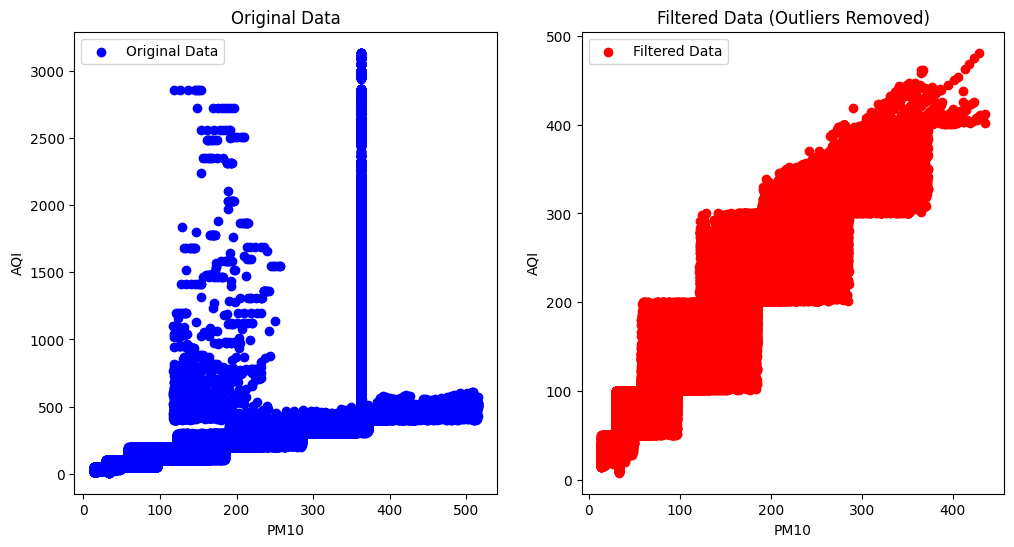

In [222]:
# Create scatter plot of original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 1], y, color='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('PM10')
plt.ylabel('AQI')
plt.legend()

# Create scatter plot of filtered data
plt.subplot(1, 2, 2)
plt.scatter(X_filtered[:, 1], y_filtered, color='red', label='Filtered Data')
plt.title('Filtered Data (Outliers Removed)')
plt.xlabel('PM10')
plt.ylabel('AQI')
plt.legend()

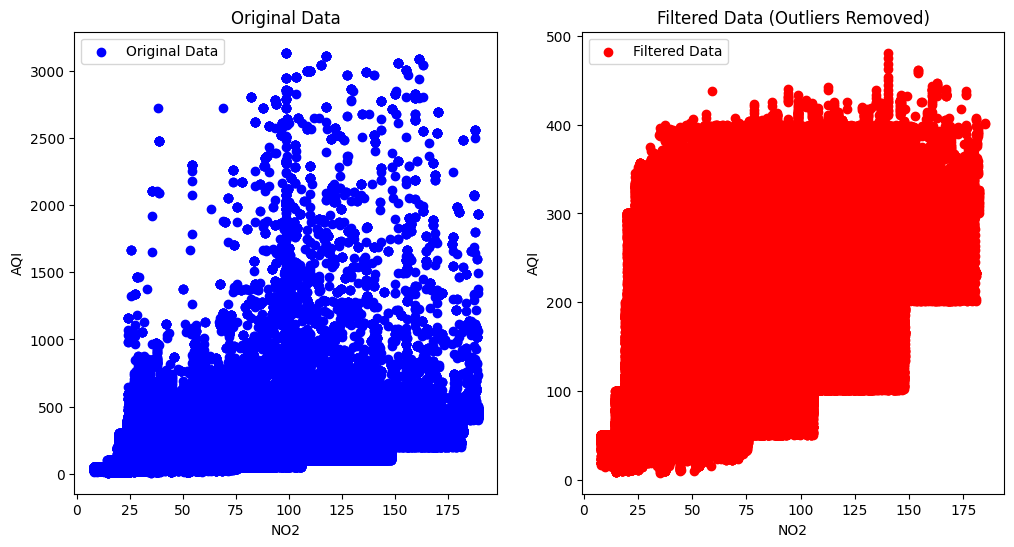

In [223]:
# Create scatter plot of original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 2], y, color='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('NO2')
plt.ylabel('AQI')
plt.legend()

# Create scatter plot of filtered data
plt.subplot(1, 2, 2)
plt.scatter(X_filtered[:, 2], y_filtered, color='red', label='Filtered Data')
plt.title('Filtered Data (Outliers Removed)')
plt.xlabel('NO2')
plt.ylabel('AQI')
plt.legend()

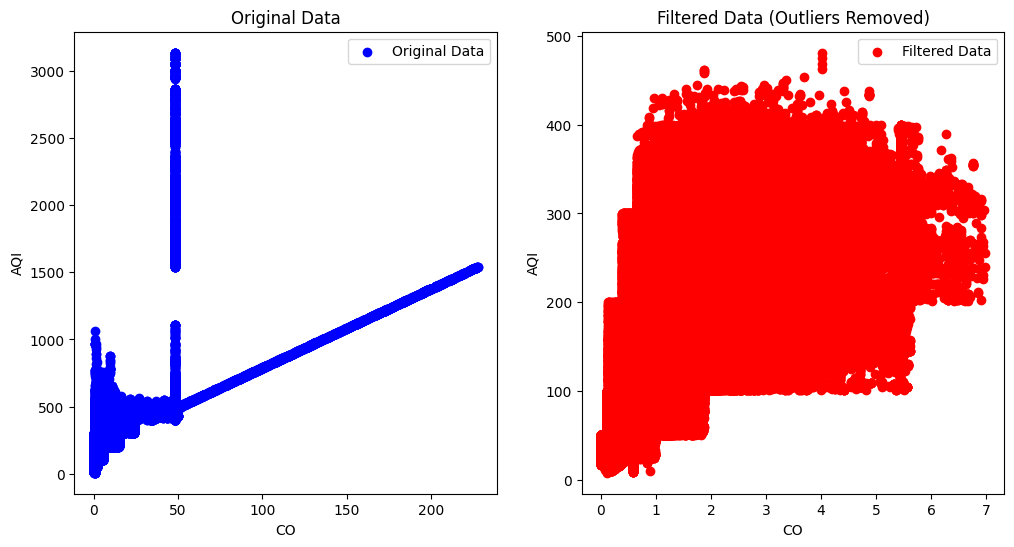

In [224]:
# Create scatter plot of original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 3], y, color='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('CO')
plt.ylabel('AQI')
plt.legend()

# Create scatter plot of filtered data
plt.subplot(1, 2, 2)
plt.scatter(X_filtered[:, 3], y_filtered, color='red', label='Filtered Data')
plt.title('Filtered Data (Outliers Removed)')
plt.xlabel('CO')
plt.ylabel('AQI')
plt.legend()

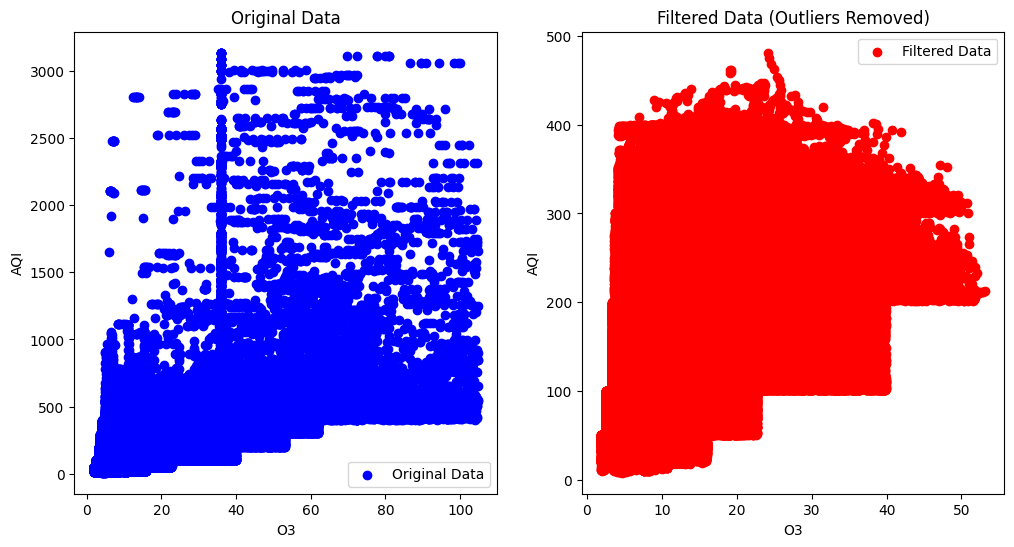

In [225]:
# Create scatter plot of original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 4], y, color='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('O3')
plt.ylabel('AQI')
plt.legend()

# Create scatter plot of filtered data
plt.subplot(1, 2, 2)
plt.scatter(X_filtered[:, 4], y_filtered, color='red', label='Filtered Data')
plt.title('Filtered Data (Outliers Removed)')
plt.xlabel('O3')
plt.ylabel('AQI')
plt.legend()

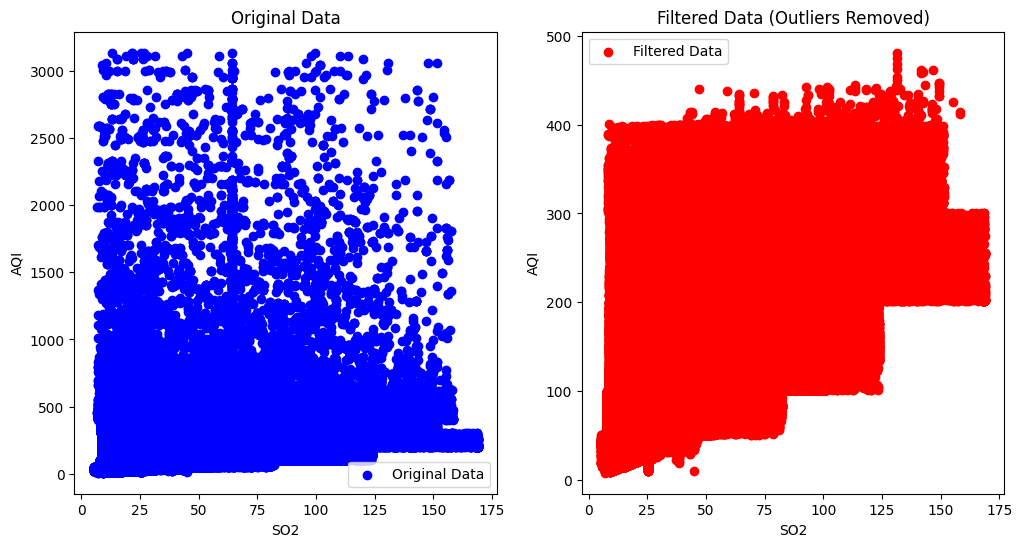

In [226]:
# Create scatter plot of original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 5], y, color='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('SO2')
plt.ylabel('AQI')
plt.legend()

# Create scatter plot of filtered data
plt.subplot(1, 2, 2)
plt.scatter(X_filtered[:, 5], y_filtered, color='red', label='Filtered Data')
plt.title('Filtered Data (Outliers Removed)')
plt.xlabel('SO2')
plt.ylabel('AQI')
plt.legend()

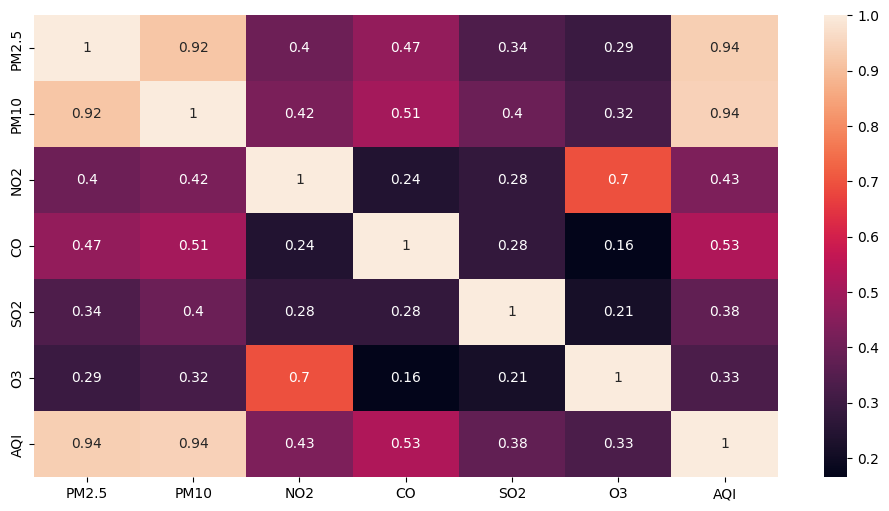

In [227]:
plot_corr_matrix(df_filtered)

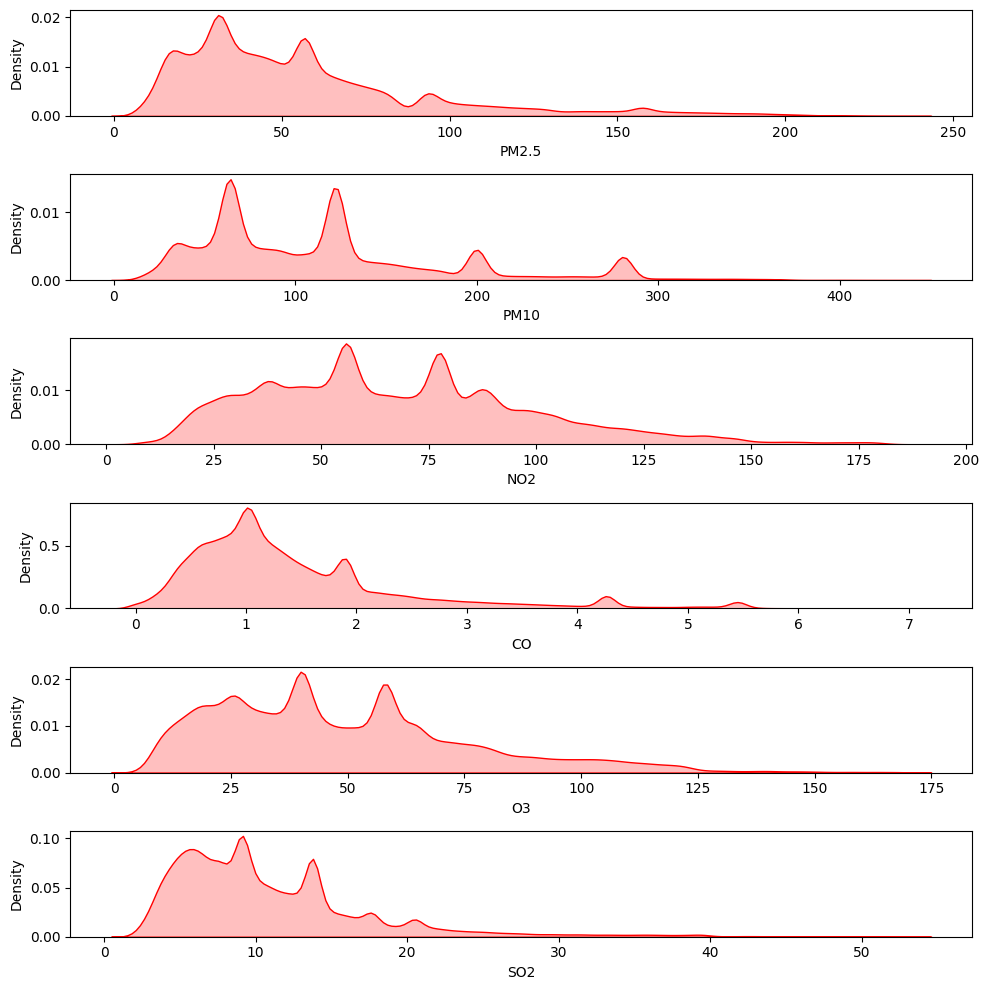

In [228]:
column_density(df_filtered, columns)

In [229]:
df_filtered.columns

Index(['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI', 'City', 'Datetime',
       'AQI_Bucket'],
      dtype='object')

In [230]:
df_filtered.isna().sum()

PM2.5         0
PM10          0
NO2           0
CO            0
SO2           0
O3            0
AQI           0
City          0
Datetime      0
AQI_Bucket    0
dtype: int64

In [231]:
column_order = ['Datetime', 'City', 'PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI_Bucket', 'AQI']
df_filtered = df_filtered.reindex(columns=column_order)

In [232]:
df_filtered.to_csv('../data/clean_filtered_data.csv', index = False)

In [233]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory = False)
df_filter.head()

Datetime       City  PM2.5  PM10   NO2   CO   SO2    O3  \
0  2015-07-24 04:00:00  Ahmedabad  16.53 32.85 13.83 0.58 13.30 25.52   
1  2015-07-24 05:00:00  Ahmedabad  16.53 32.85 13.83 0.58 13.23 25.52   
2  2015-07-24 06:00:00  Ahmedabad  16.53 32.85 13.83 0.58 12.87 25.52   
3  2015-07-24 07:00:00  Ahmedabad  16.53 32.85 13.83 0.58 12.66 25.52   
4  2015-07-24 08:00:00  Ahmedabad  16.53 32.85 13.83 0.58 12.72 25.52   

  AQI_Bucket   AQI  
0       Good 50.00  
1       Good 49.00  
2       Good 48.00  
3       Good 48.00  
4       Good 49.00

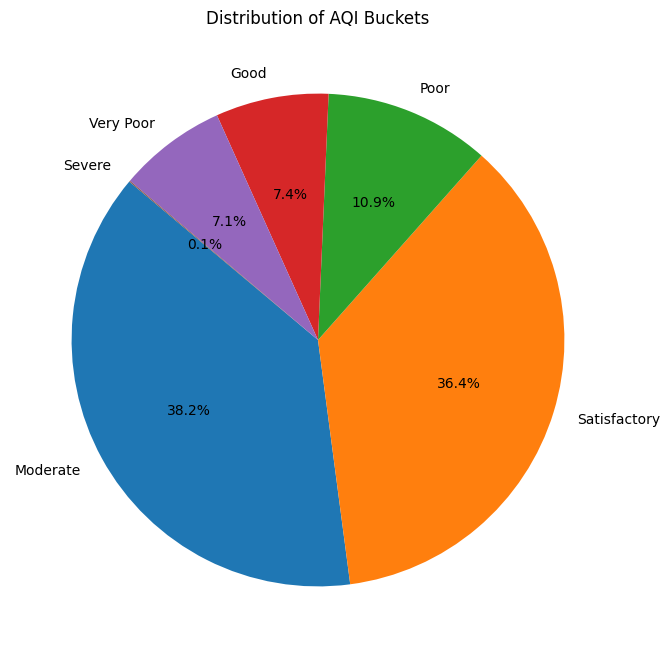

In [234]:
aqi_bucket_percentages = (df_filtered['AQI_Bucket'].value_counts() / len(df_filtered)) * 100
plt.figure(figsize=(8, 8))
plt.pie(aqi_bucket_percentages, labels=aqi_bucket_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of AQI Buckets')
plt.show()

In [235]:
def plot_regression_diagnostic_plots(y_train, y_train_pred, y_test, y_test_pred):

    train_residual = y_train - y_train_pred
    test_residual = y_test - y_test_pred
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    # Scatter Plot of Actual vs. Predicted Values
    sns.scatterplot(x=y_test_pred, y=y_test, ax=axes[0, 0])
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    axes[0, 0].set_title("Actual vs. Predicted")
    axes[0, 0].set_xlabel("Predicted")
    axes[0, 0].set_ylabel("Actual")

    # Residual Plot
    sns.scatterplot(x=y_test_pred, y=test_residual, ax=axes[0, 1])
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_title("Residual Plot")
    axes[0, 1].set_xlabel("Predicted")
    axes[0, 1].set_ylabel("Residuals")

    # KDE Plot of y_test and y_test_pred
    sns.kdeplot(y_test, label='True', ax=axes[1, 0])
    sns.kdeplot(y_test_pred, label='Predicted', ax=axes[1, 0])
    axes[1, 0].set_title("KDE Plot of True vs. Predicted")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Density")
    axes[1, 0].legend()

    # Histogram of Residuals
    sns.histplot(test_residual, ax=axes[1, 1], kde=True)
    axes[1, 1].set_title("Histogram of Residuals")
    axes[1, 1].set_xlabel("Residuals")

    # Q-Q Plot
    import scipy.stats as stats
    stats.probplot(test_residual, dist="norm", plot=axes[2, 0])
    axes[2, 0].set_title("Q-Q Plot")

    # Fitted vs. Residual Plot
    sns.kdeplot(train_residual, label='Train Diff', color='blue', linestyle='-', ax=axes[2,1])
    sns.kdeplot(test_residual, label='Test Diff', color='orange', linestyle='--', ax=axes[2,1])
    axes[2, 1].set_xlabel('Prediction Difference')
    axes[2, 1].set_ylabel('Density')
    axes[2, 1].set_title('Kernel Density Estimation of Prediction Differences')
    axes[2, 1].legend()

    # Show plots
    plt.tight_layout()
    plt.show()

In [236]:
X, y = df_filter[['PM2.5', 'PM10']], df_filter['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

0.947041134681217


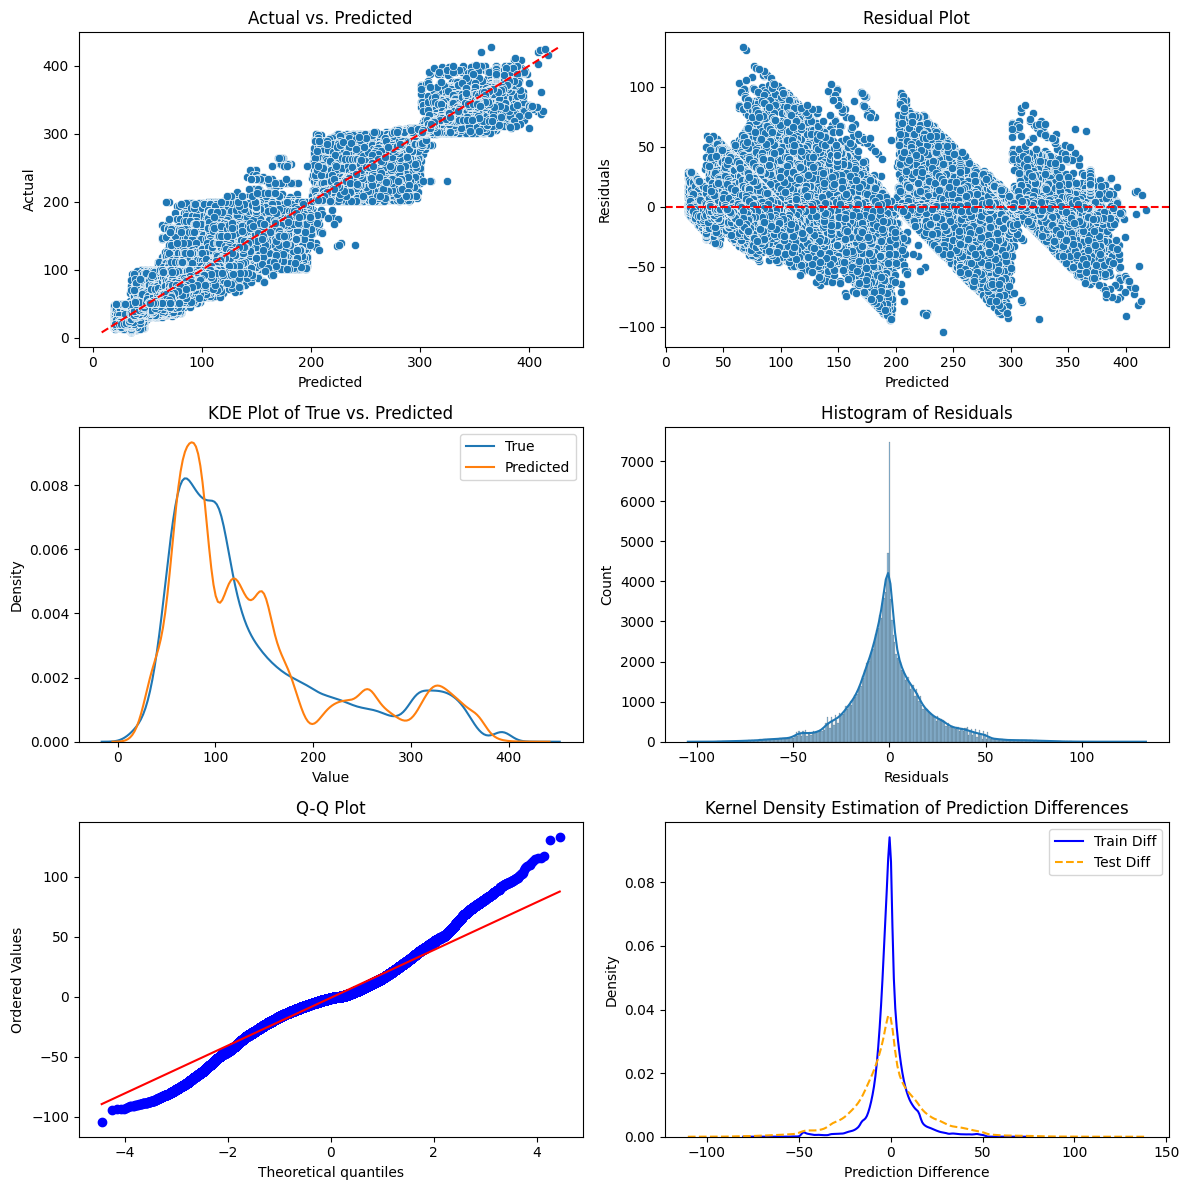

In [237]:
plot_regression_diagnostic_plots(y_train, y_pred_train, y_test, y_pred_test)

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Split the data into training and testing sets
X, y = df_filter[['PM2.5', 'PM10']], df_filter['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Ridge regression model with regularization (L2 penalty)
alpha = 0.1  # Regularization strength, adjust as needed
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

# Evaluate the model
r2_score = ridge_model.score(X_test, y_test)
print("R-squared score:", r2_score)

# Make predictions
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)

R-squared score: 0.925218085830579


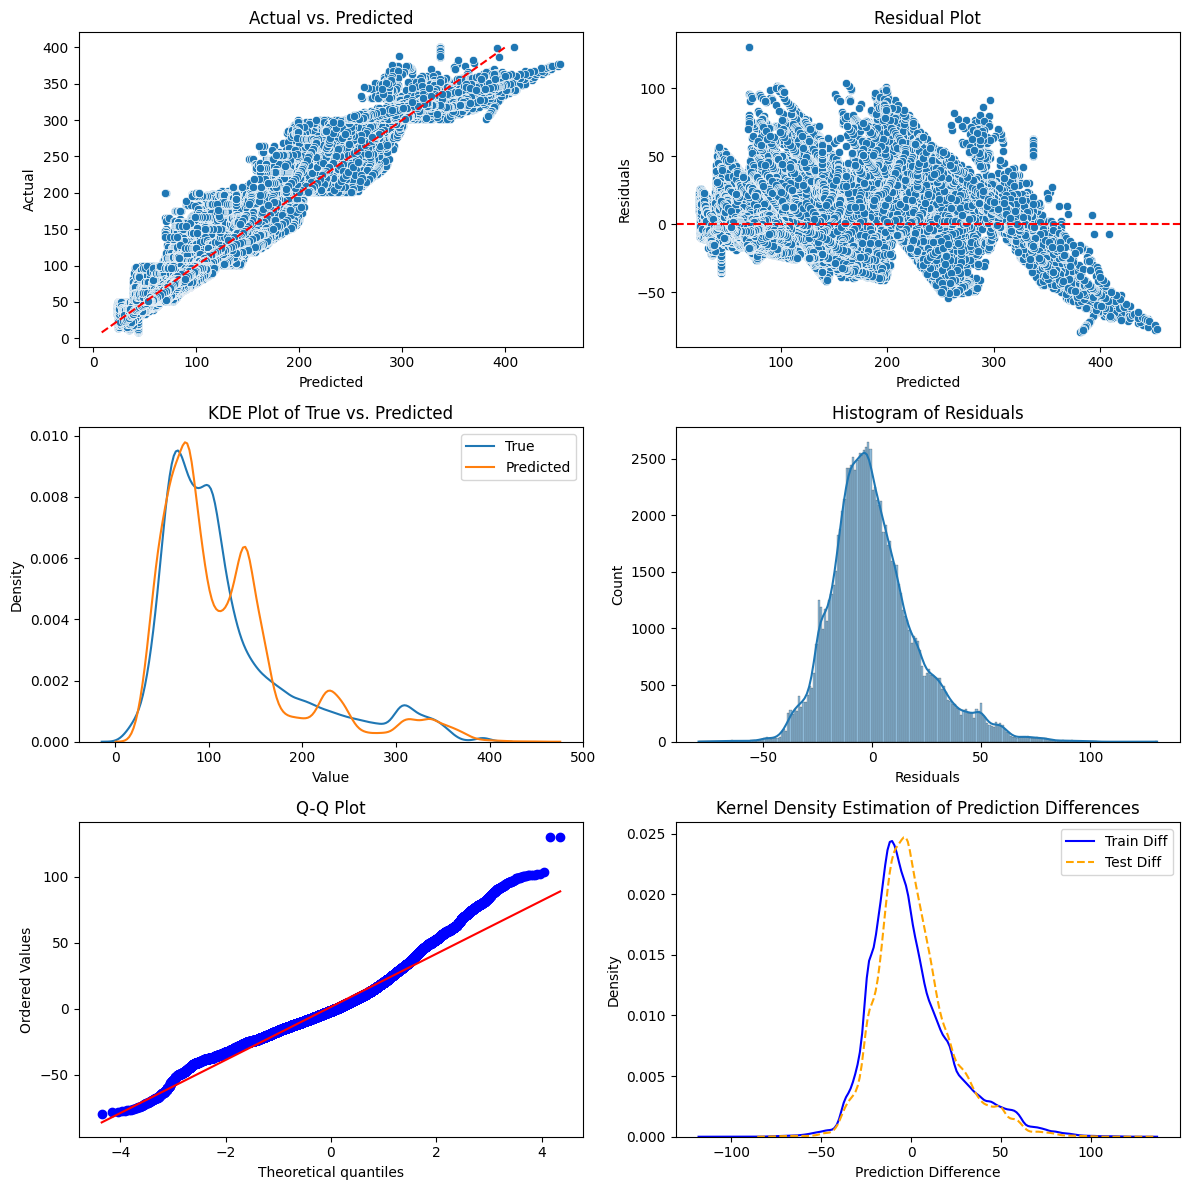

In [239]:
plot_regression_diagnostic_plots(y_train, y_pred_train, y_test, y_pred_test)

In [240]:
from sklearn.linear_model import ElasticNet

# Train the ElasticNet regression model with L2 penalty
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # Adjust alpha and l1_ratio as needed
elastic_net.fit(X_train, y_train)

# Evaluate the model
r2_score_en = elastic_net.score(X_test, y_test)
print("R-squared score (ElasticNet):", r2_score_en)

# Make predictions
y_pred_train = elastic_net.predict(X_train)
y_pred_test = elastic_net.predict(X_test)

R-squared score (ElasticNet): 0.9252185269299026


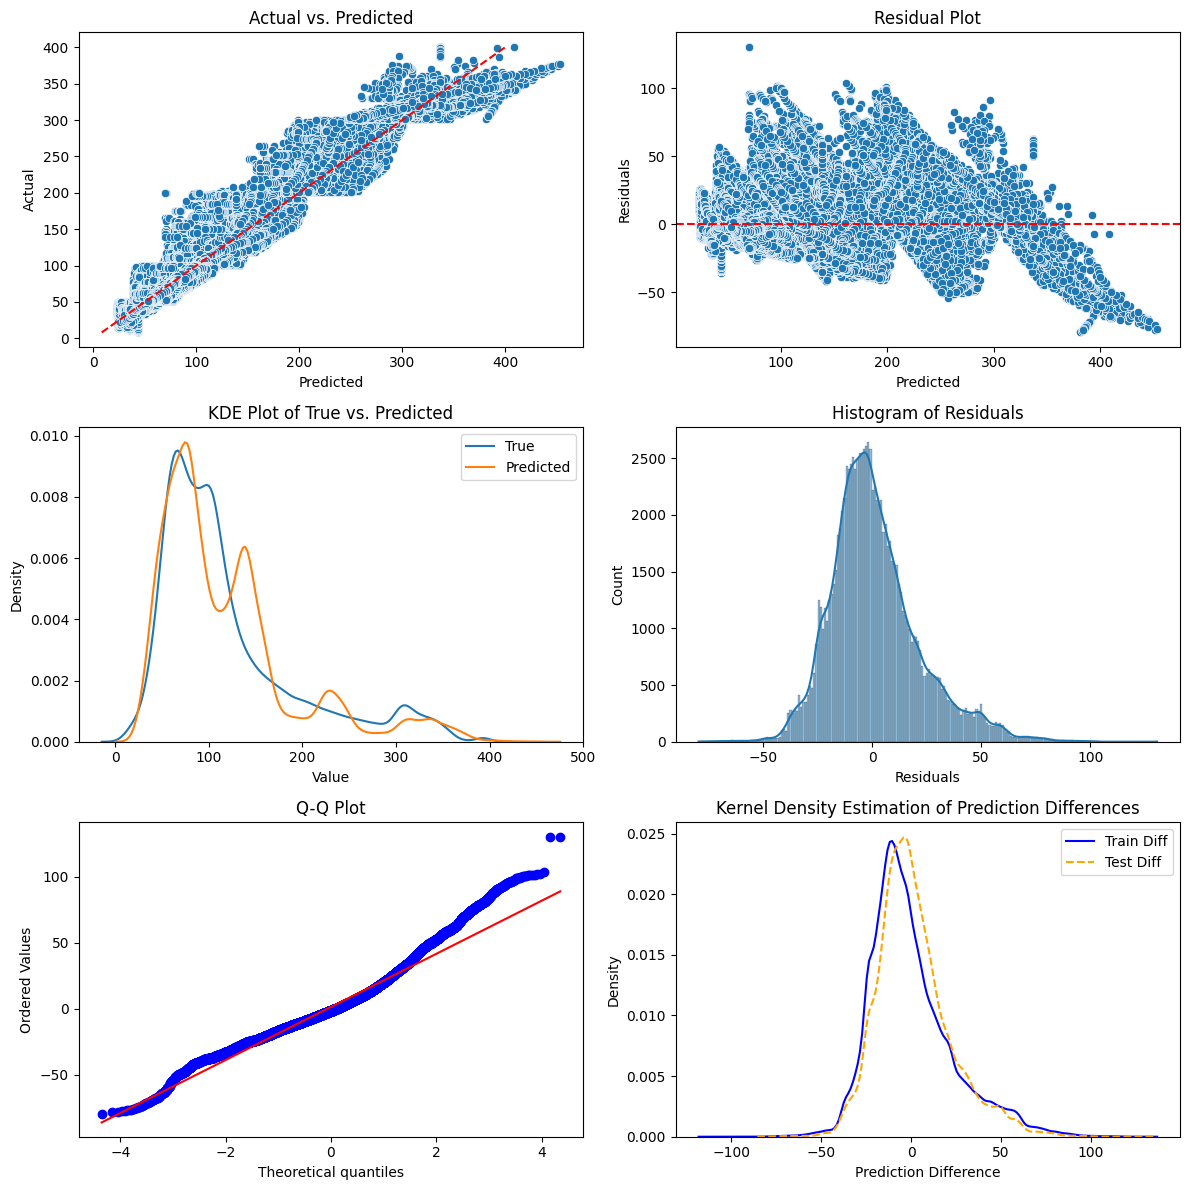

In [241]:
plot_regression_diagnostic_plots(y_train, y_pred_train, y_test, y_pred_test)

In [242]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split the data into training and testing sets
X, y = df_filter[['PM2.5', 'PM10']], df_filter['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}  # Values of alpha to try

# Initialize the Ridge regression model
ridge_model = Ridge()

# Create the GridSearchCV object
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='r2')

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameter
best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Train the Ridge regression model with the best parameters
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train, y_train)

# Evaluate the model
r2_score = best_ridge_model.score(X_test, y_test)
print("R-squared score:", r2_score)

# Make predictions
y_pred_train = best_ridge_model.predict(X_train)
y_pred_test = best_ridge_model.predict(X_test)

Best alpha: 0.001
R-squared score: 0.9252180858288275


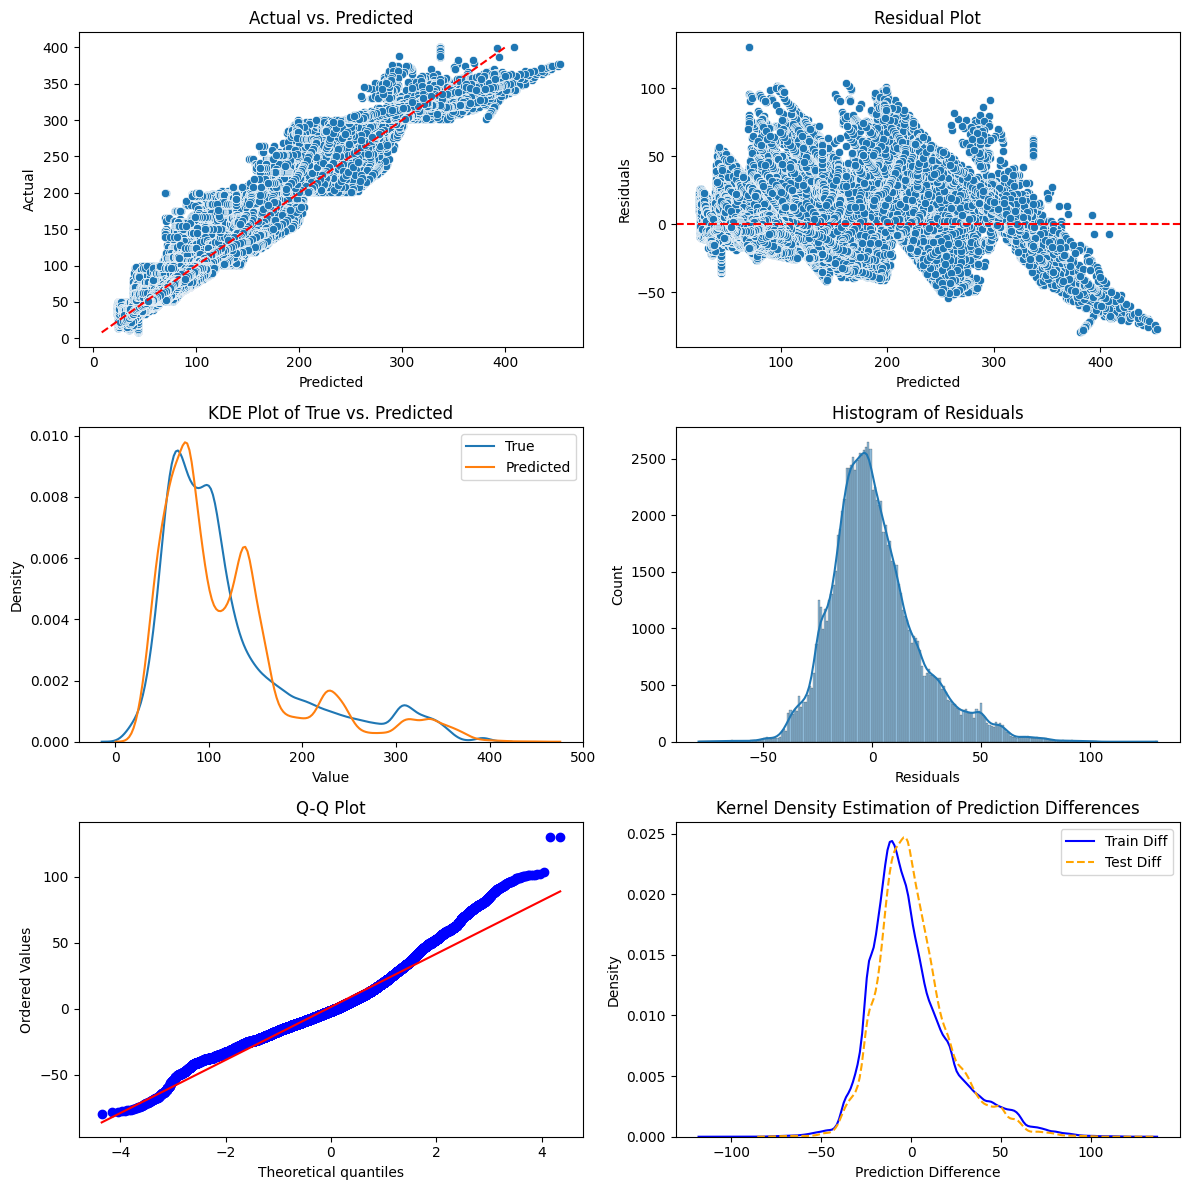

In [243]:
plot_regression_diagnostic_plots(y_train, y_pred_train, y_test, y_pred_test)

In [244]:
X, y = df_filter[['PM2.5', 'PM10']], df_filter['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)
model = XGBRegressor(n_estimators=500, alpha = 100, learning_rate = 0.1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

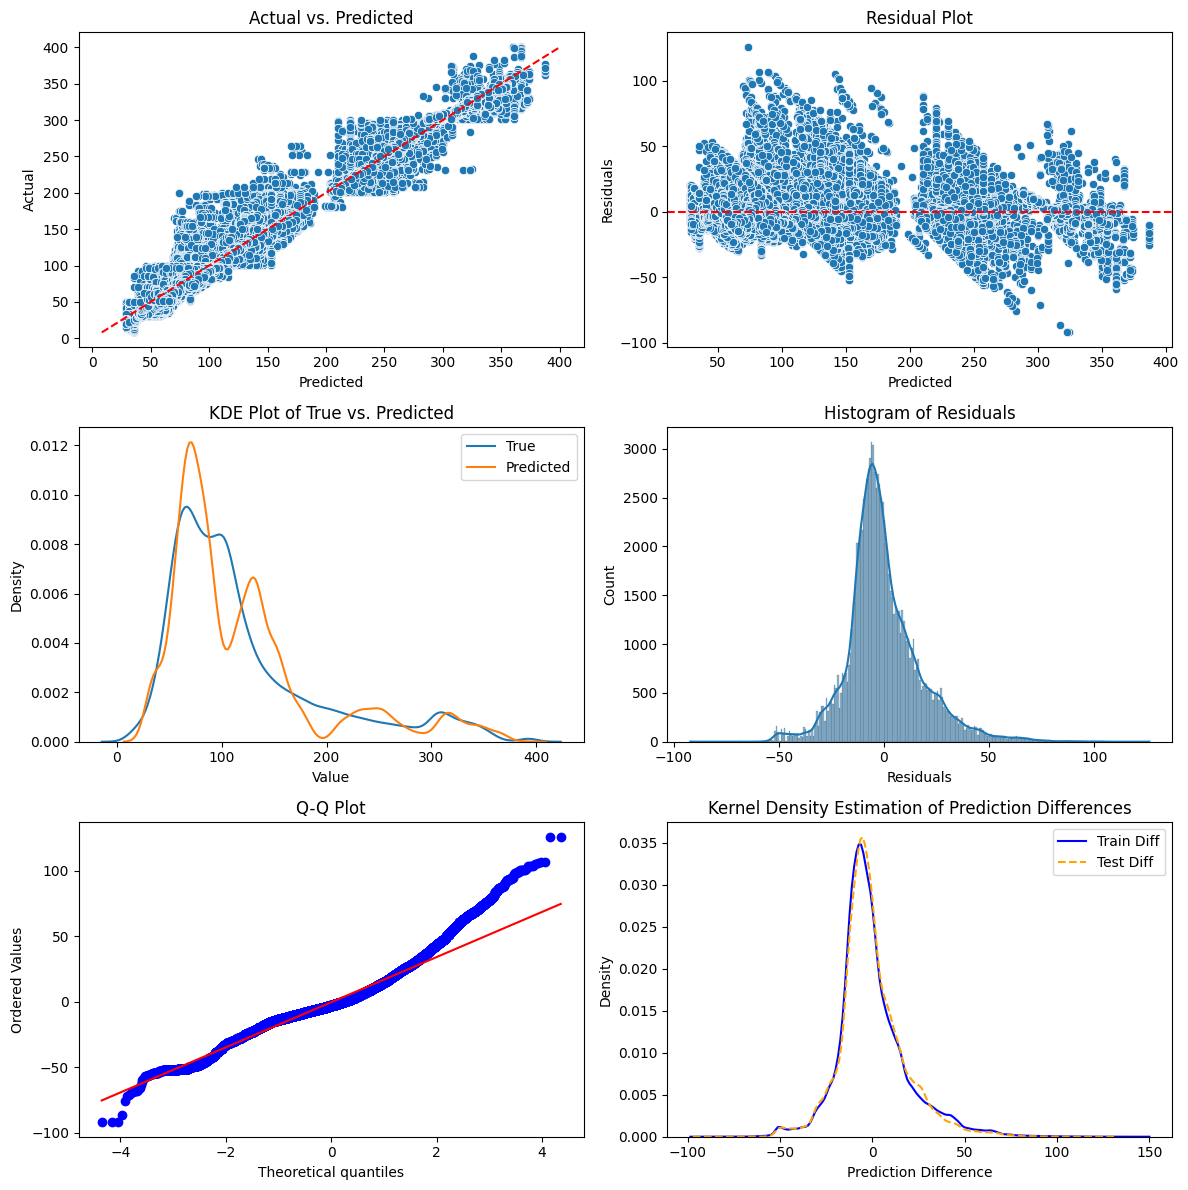

In [245]:
plot_regression_diagnostic_plots(y_train, y_pred_train, y_test, y_pred_test)

In [ ]:
def df_split_scale(df, scaler='ss', test_size=0.3, shuffle=True, scale=False):
    # Splitting the data
    X, y = df[['PM2.5', 'PM10']], df['AQI']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle)

    if scale == True: # scaling
        if scaler == 'ss':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            return X_train_scaled, X_test_scaled, y_train, y_test, scaler
        elif scaler == 'mm':
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            return X_train_scaled, X_test_scaled, y_train, y_test, scaler
        else:
            return X_train, X_test, y_train, y_test, None
    else:  # no scaling
        return X_train, X_test, y_train, y_test, None

Before training model actually lets experiment a bit on scaled and non-scaled data to see how they performs. Meanwhile, doing these we are going to check cross_validation scores and also check the kdeplot of the test and predicted data

In [ ]:
def preprocess_plot_score(df, test_size=0.3, model=LinearRegression(), shuffle=True, scaler='ss', scale=False):
    # Splitting the data and scaling
    X_train, X_test, y_train, y_test, _ = df_split_scale(df, scaler=scaler, test_size=test_size, shuffle=shuffle, scale=scale)

    # Training the model
    model = model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Cross-validation scores
    cv_scores = -1 * cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Plotting KDE with axes and cross-validation scores
    plot_regression_diagnostic_plots(y_train, y_train_pred, y_test, y_test_pred)
    print(cv_scores.mean())

    # Evaluate the model
    train_score = 1 * mean_squared_error(y_train, y_train_pred)
    test_score = 1 * mean_squared_error(y_test, y_test_pred)

    return model, train_score, test_score, cv_scores

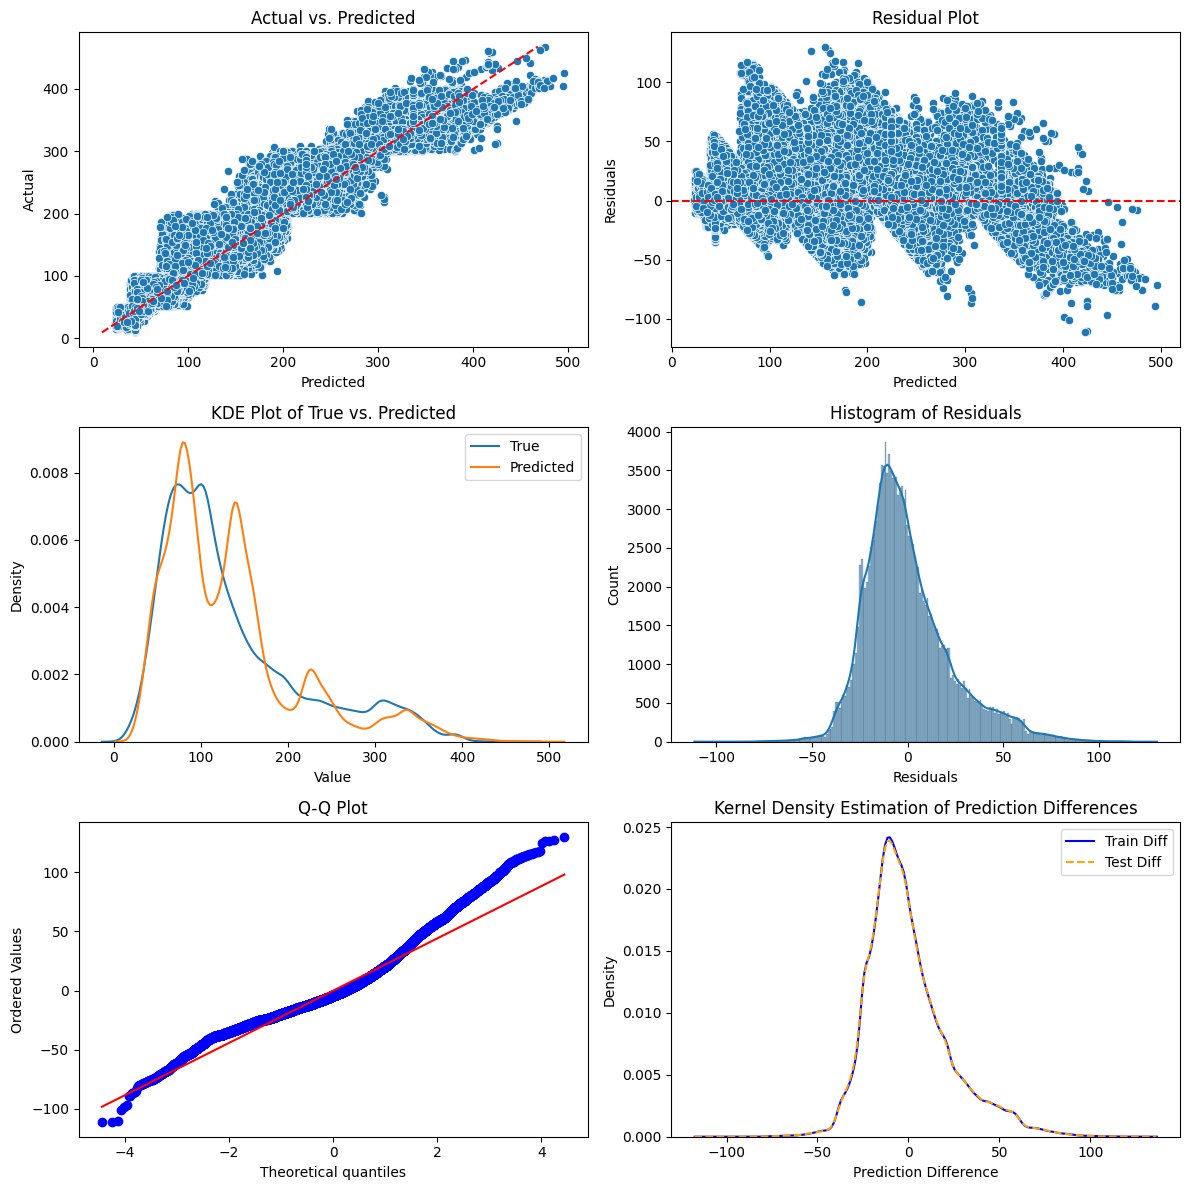

514.0683168385101
Training Score: 514.0540330789161
Testing Score: 516.7861738798869
Cross_Validation Score: [521.2071432  521.68784228 508.57463018 510.81578104 508.0561875 ]


In [248]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

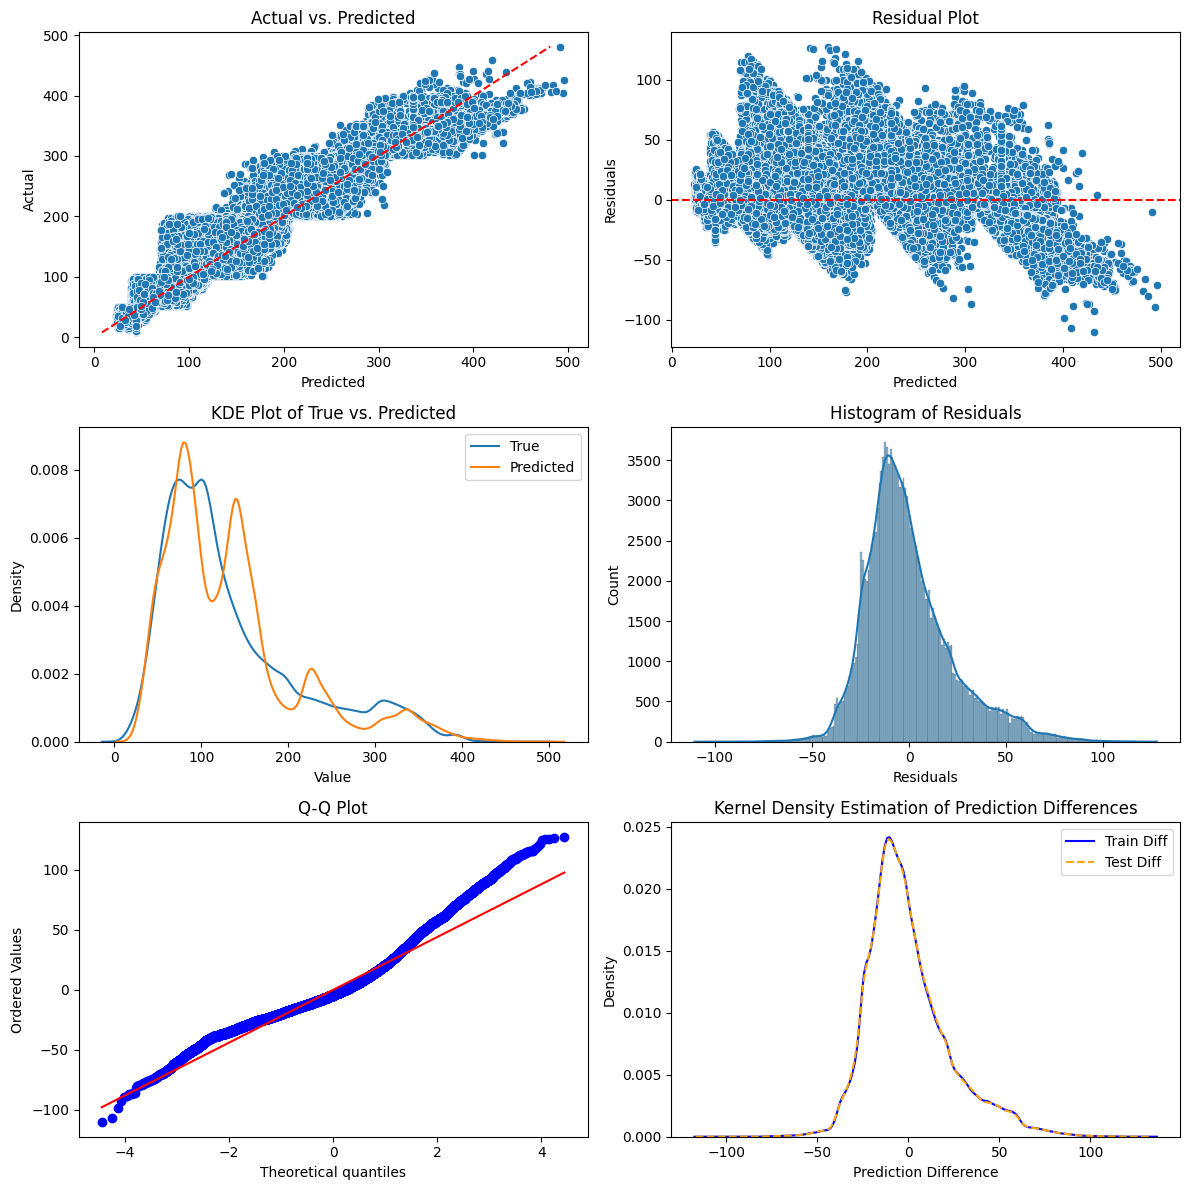

515.5504566241058
Training Score: 515.5445735488324
Testing Score: 513.3105742541113
Cross_Validation Score: [515.6613479  516.5466208  514.41006673 514.35795546 516.77629223]


In [249]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, scaler='ss', scale=True)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

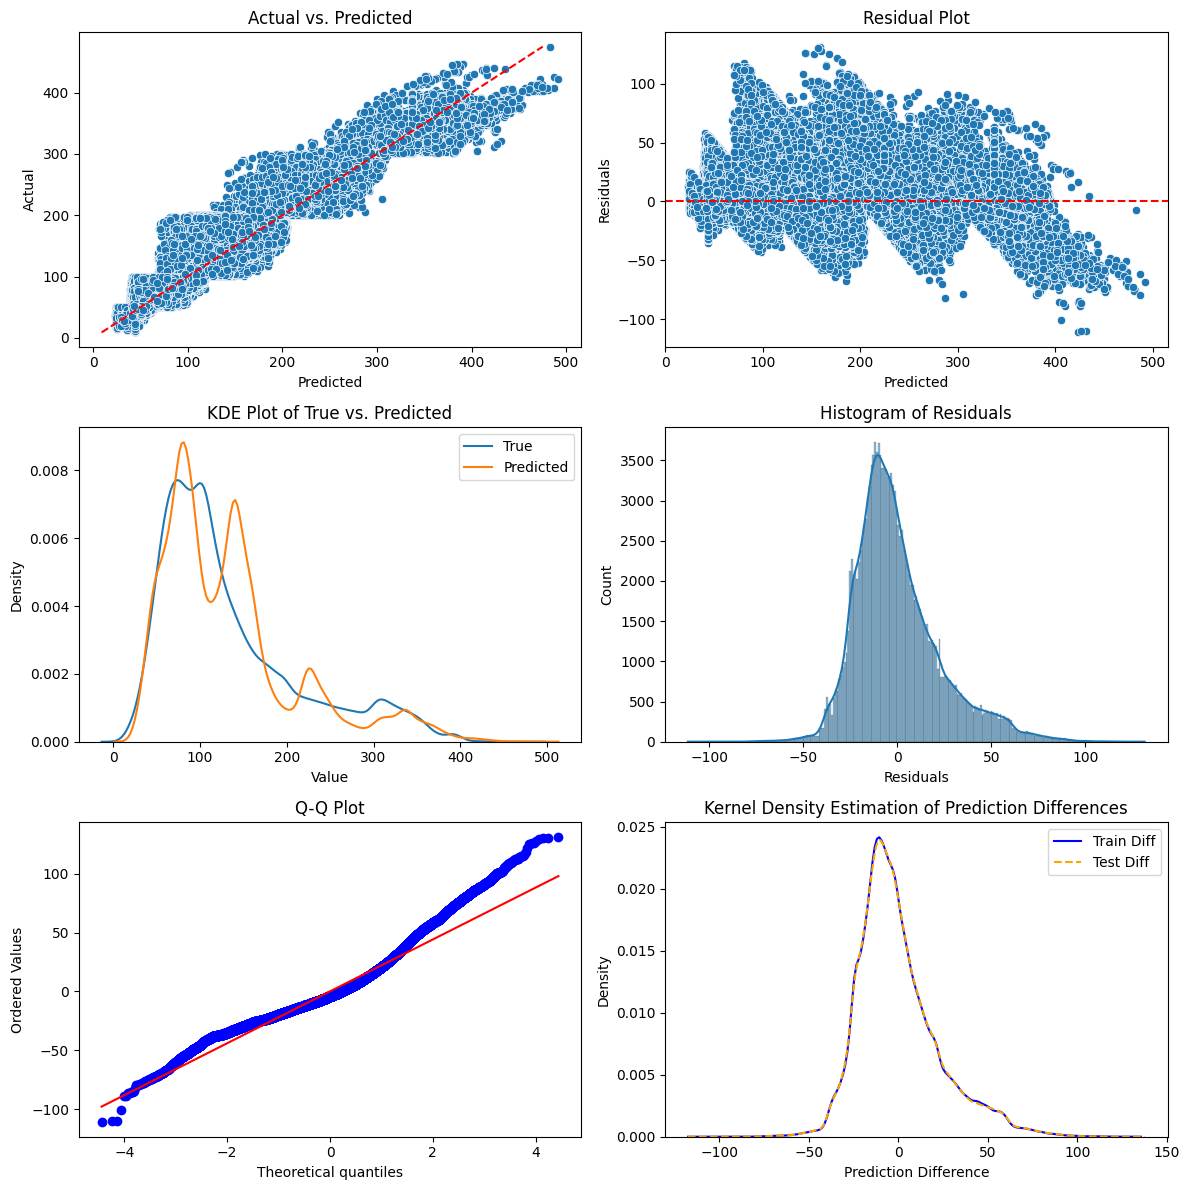

514.9515332104885
Training Score: 514.938967637687
Testing Score: 514.7200217870237
Cross_Validation Score: [515.64229479 512.08680753 512.46839666 515.84798098 518.7121861 ]


In [250]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, scaler='mm', scale=True)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

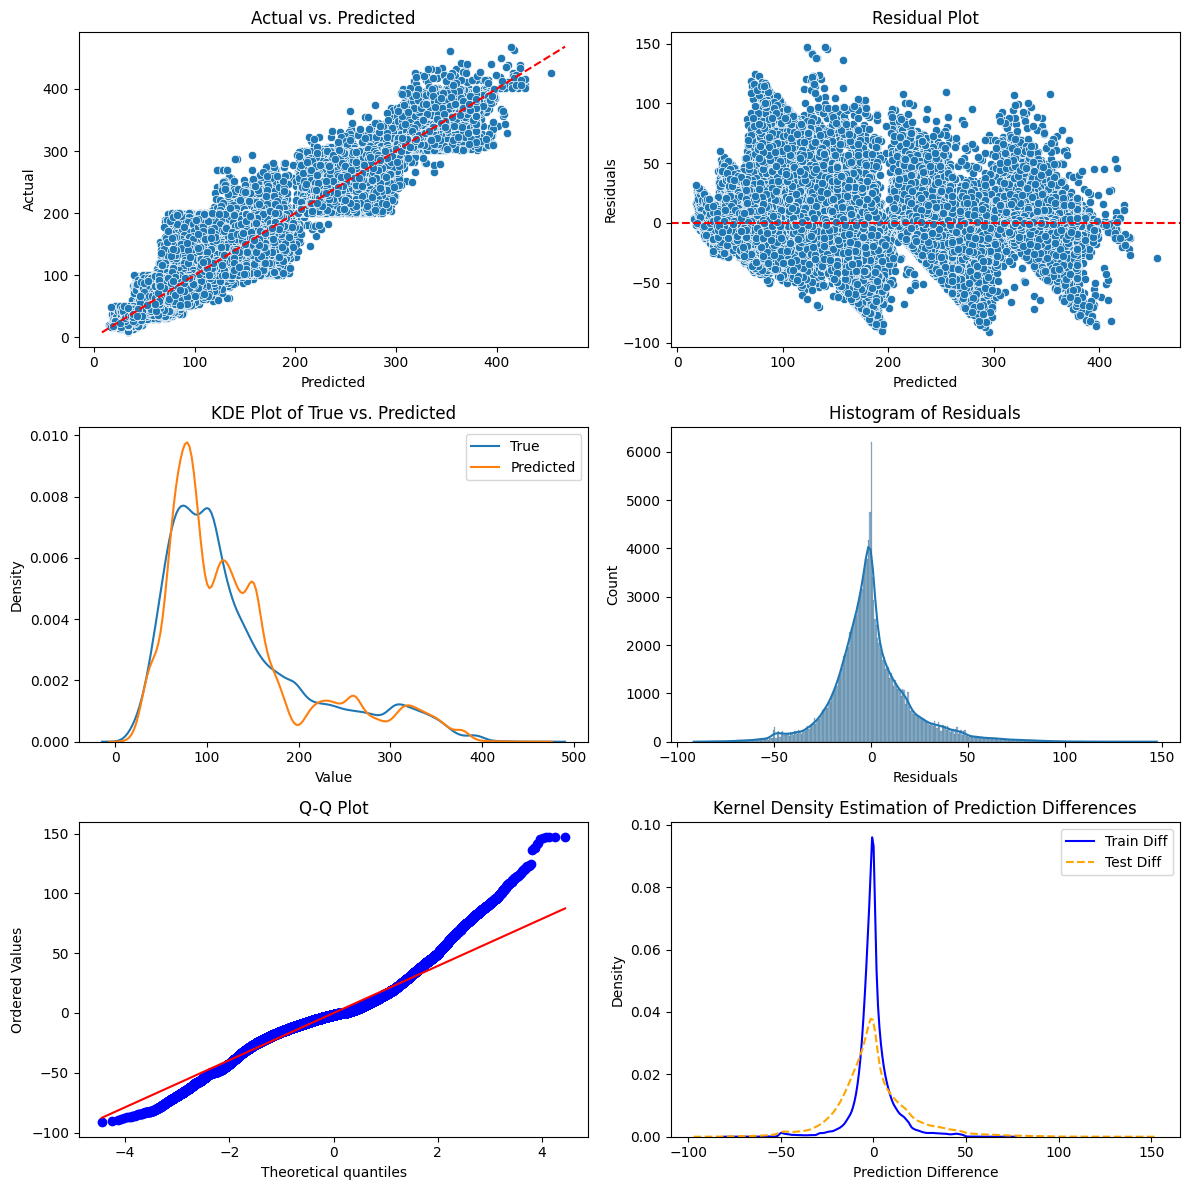

412.2374709823145
Training Score: 116.4734036502867
Testing Score: 411.5118782299762
Cross_Validation Score: [410.79315496 416.14205146 407.05201312 409.45520276 417.74493262]


In [251]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, model=RandomForestRegressor(), scaler='ss', scale=True)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

# Modelling and Hypertuning

Following models are selection for training
1. SGDRegressor
2. XGBoostRegressor
3. RandomForestRegressor
4. LBGMRegressor
5. SGDRegressor

I am training models, hypertune them and also see best performing model evaluation of neg_mean_squared_error, r2_score. Also, plot the best performing model on the basis of hypertuned parameters.

1. Model Selection
2. Model Training
3. Model Evaluation
4. Model Hypertuning

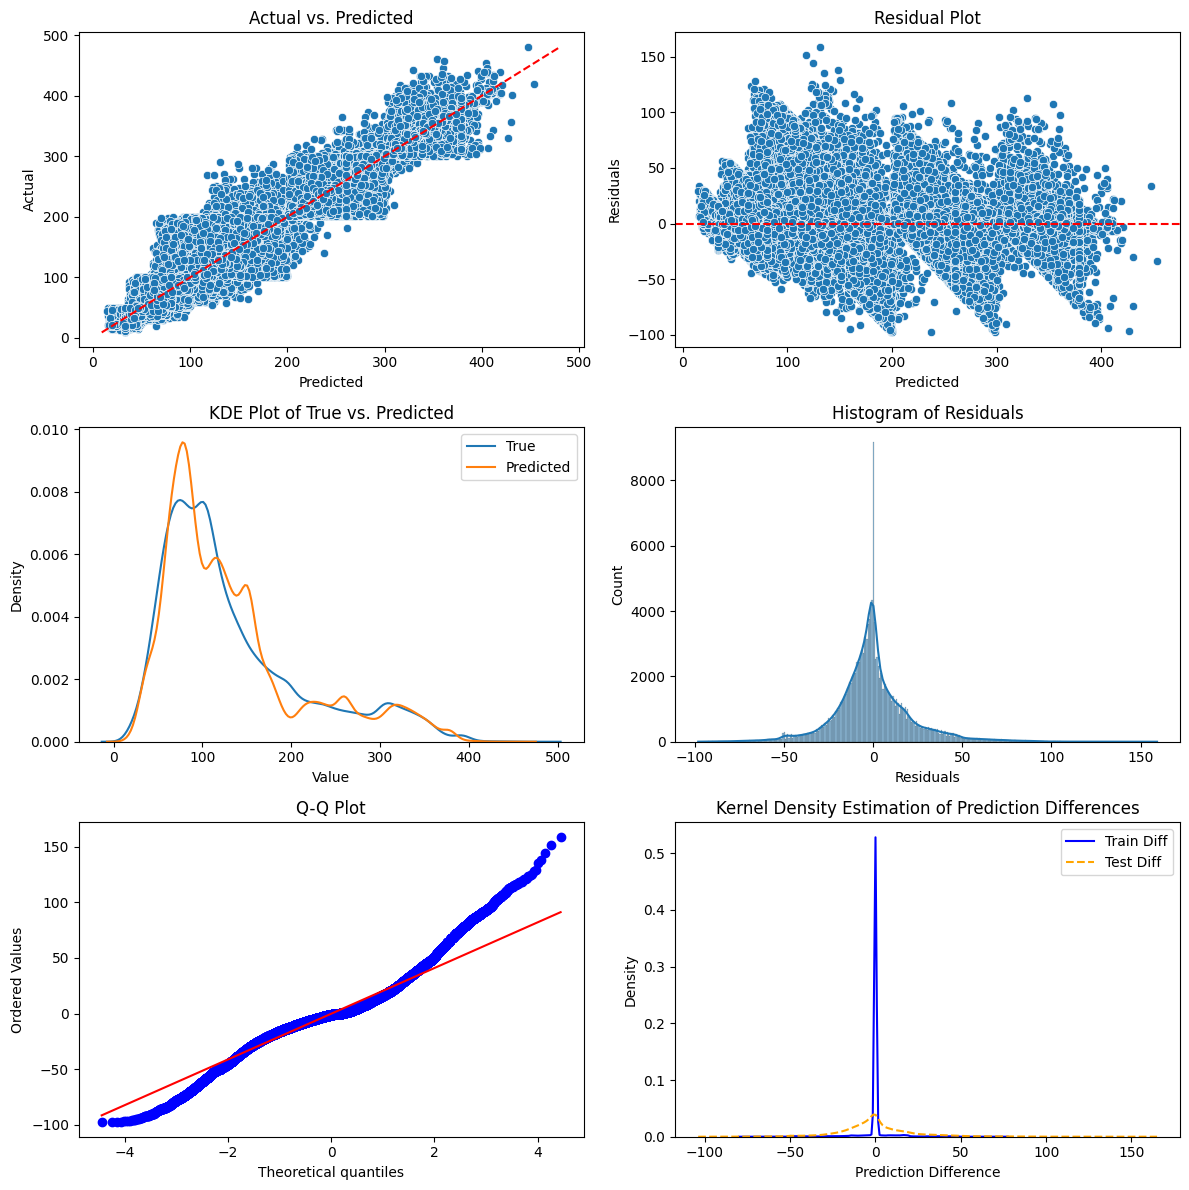

448.8620606171511
Training Score: 71.9247594340522
Testing Score: 449.1717448051788
Cross_Validation Score: [439.93398724 446.25144816 456.7470298  443.8317868  457.54605108]


In [252]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, model= ExtraTreesRegressor(), scaler='ss', scale=True)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

In [253]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge
from sklearn.linear_model import OrthogonalMatchingPursuit, Lars

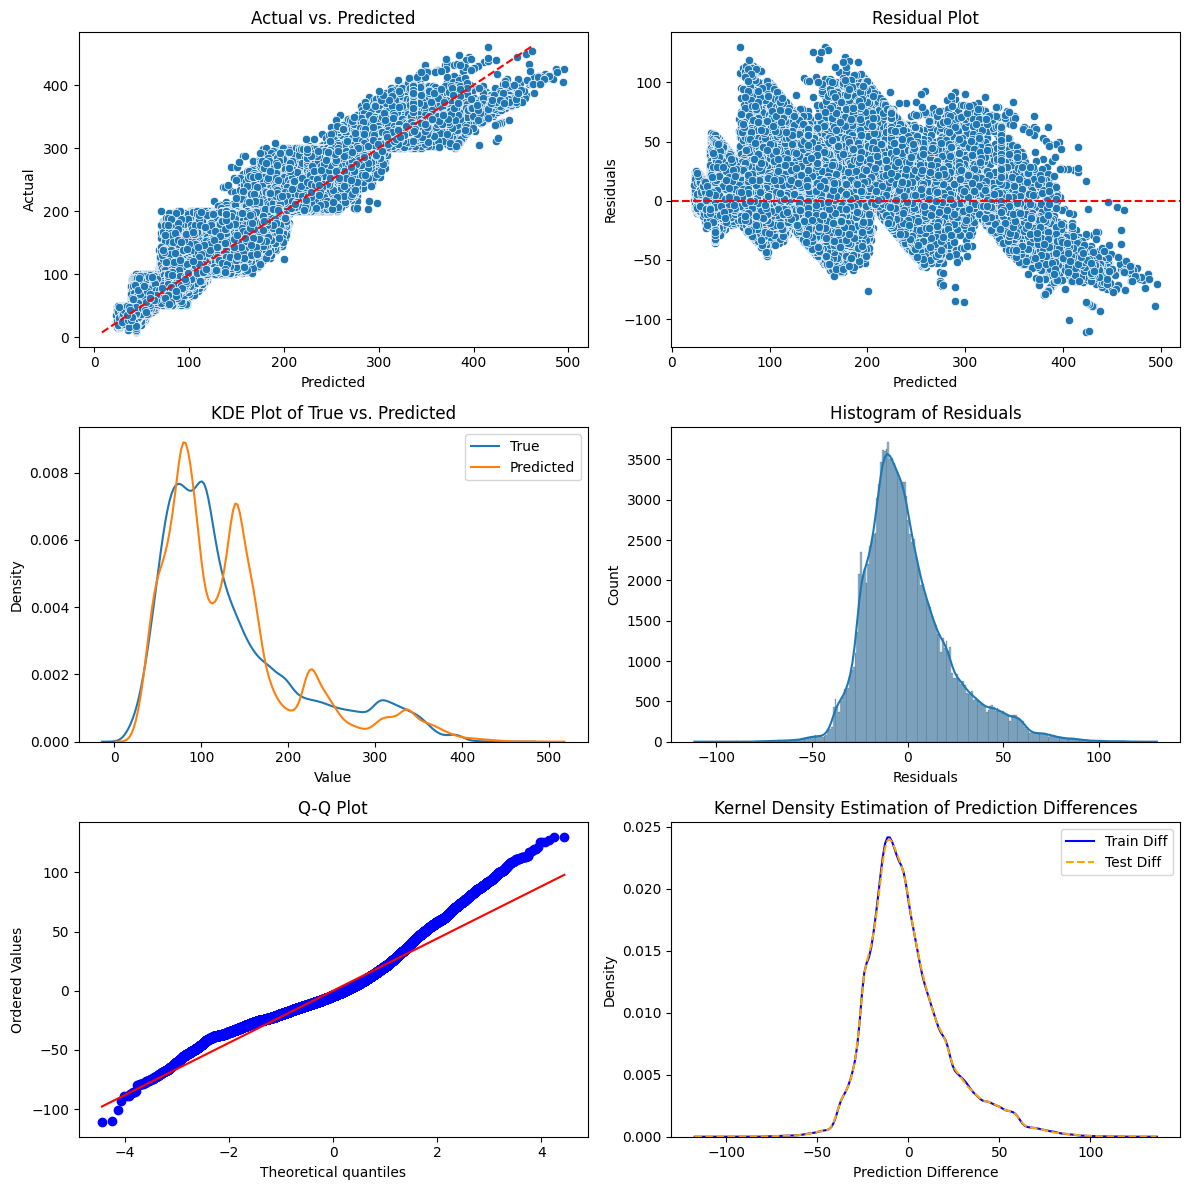

514.8922884968217
Training Score: 514.8812402129493
Testing Score: 514.8560107633955
Cross_Validation Score: [508.23266941 517.05506648 511.29836787 524.8119575  513.06338123]


In [254]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, model=ElasticNet())
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

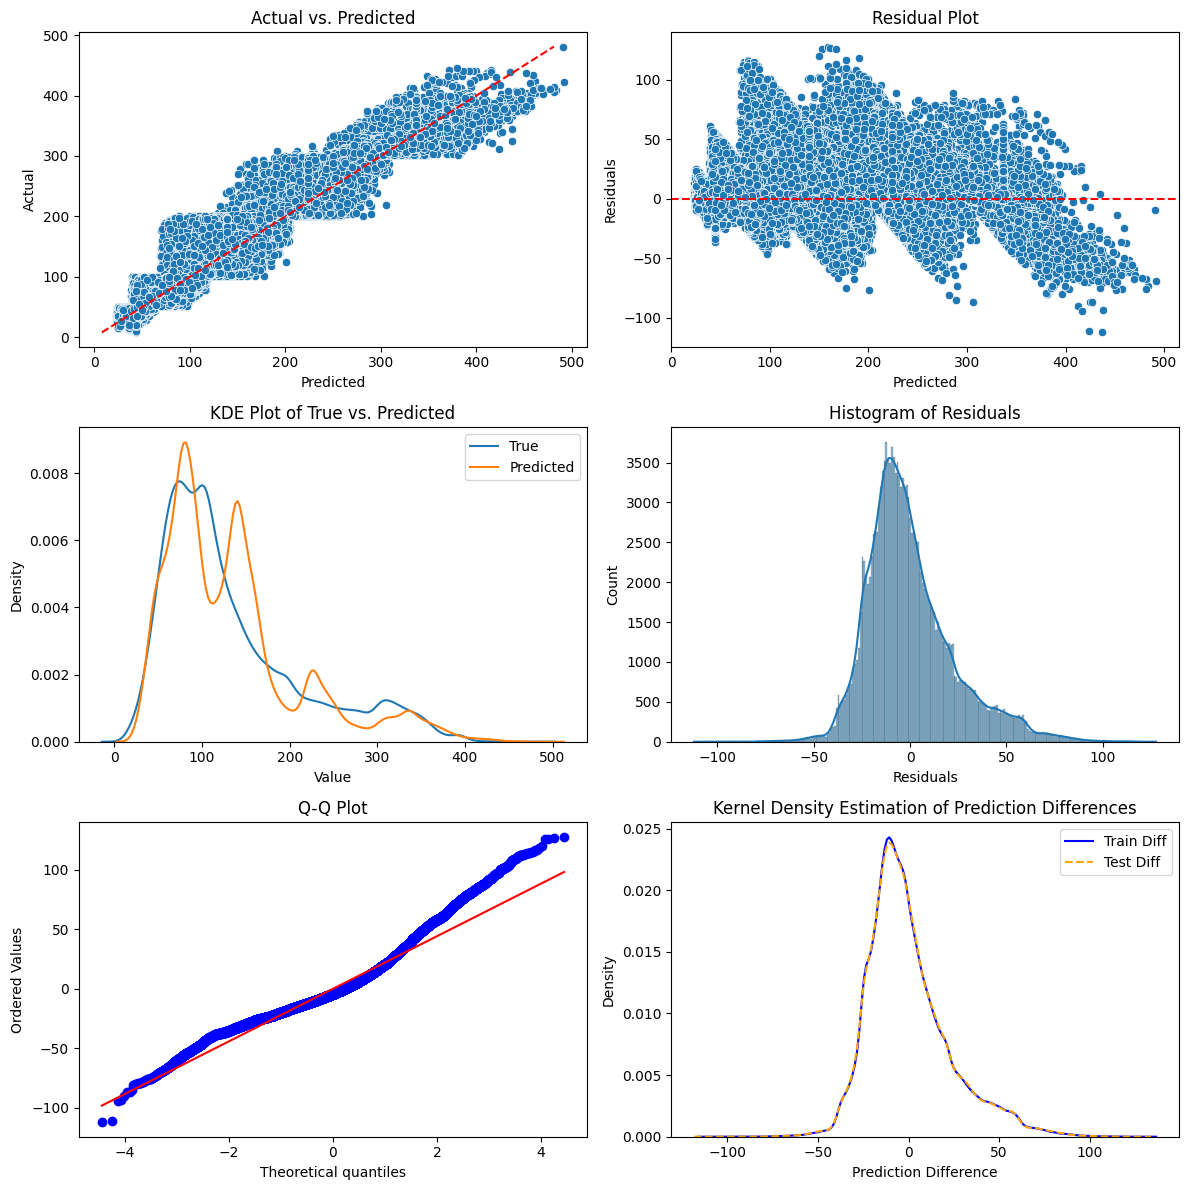

514.7238954447745
Training Score: 514.7166029118332
Testing Score: 515.2413125454274
Cross_Validation Score: [513.89295605 512.00790468 519.14199633 514.8538782  513.72274197]


In [255]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, model= Lasso())
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

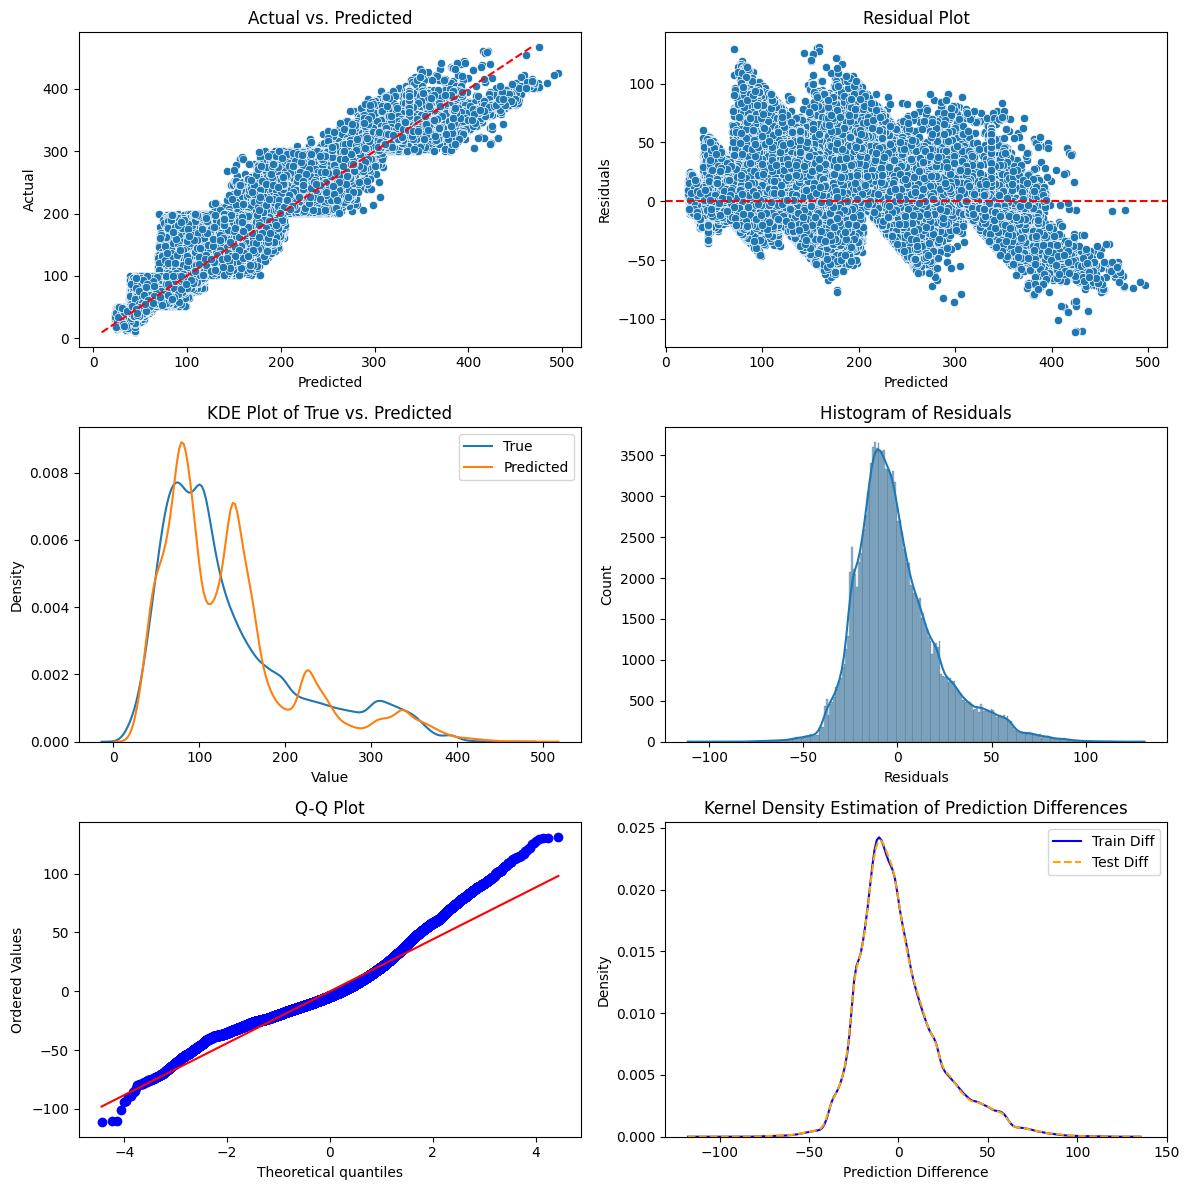

514.8521599952562
Training Score: 514.8390517410645
Testing Score: 514.9596648230596
Cross_Validation Score: [515.83078179 507.81287197 515.77379375 519.85123246 514.99212002]


In [256]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, model=BayesianRidge(), scaler='ss', scale=True)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

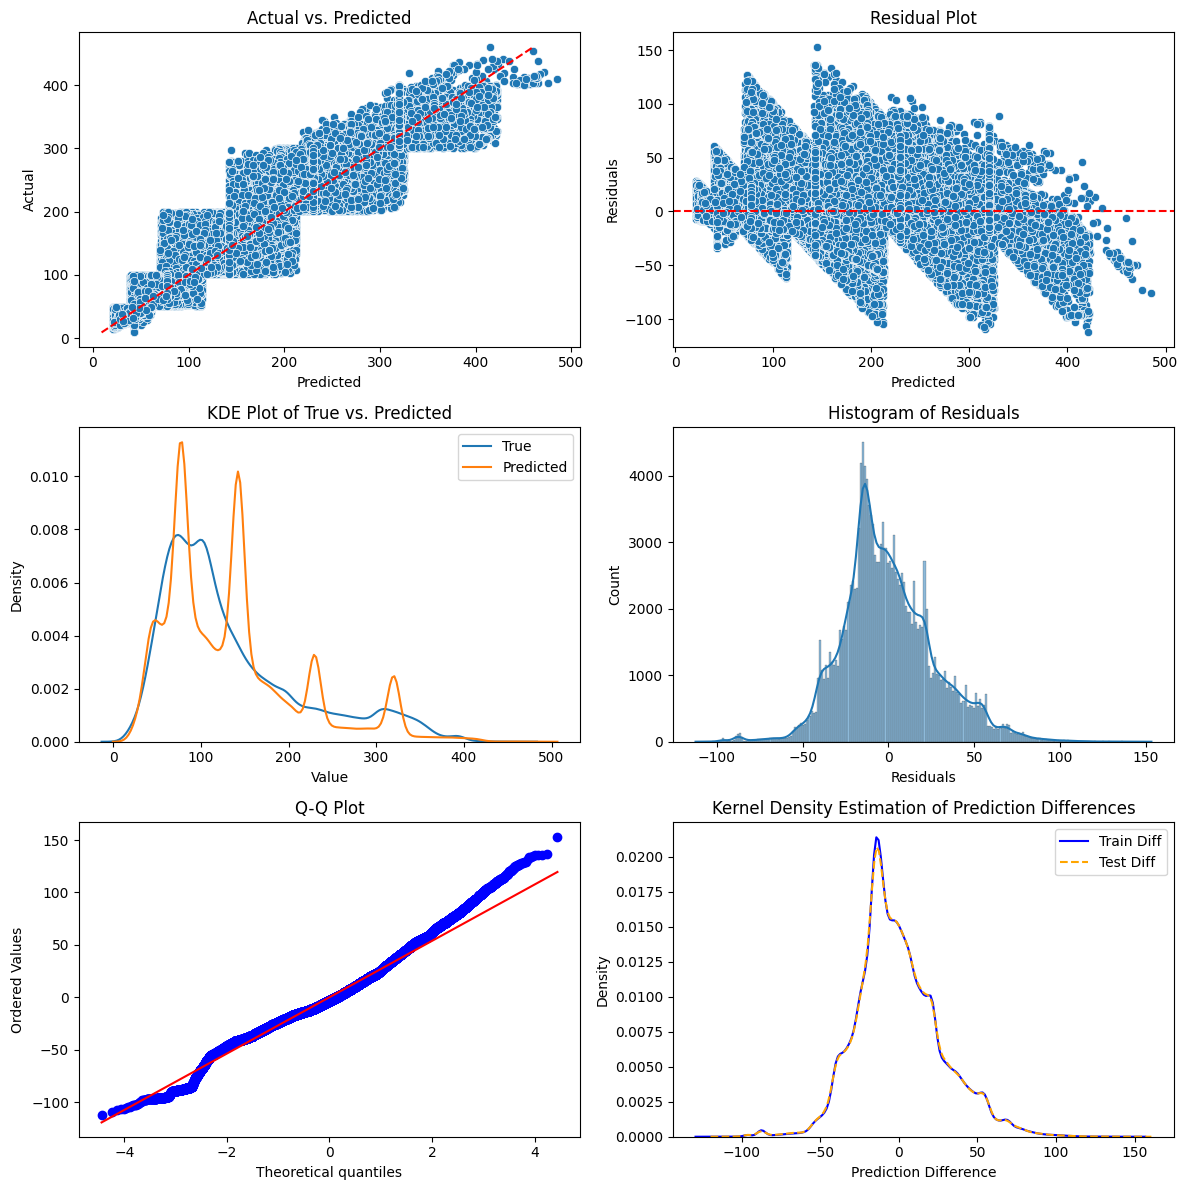

734.0683241021472
Training Score: 734.0547089888373
Testing Score: 738.4799447722694
Cross_Validation Score: [733.27333211 733.82629707 732.48219511 735.98098065 734.77881557]


In [257]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, model=OrthogonalMatchingPursuit(), scaler='ss', scale=True)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

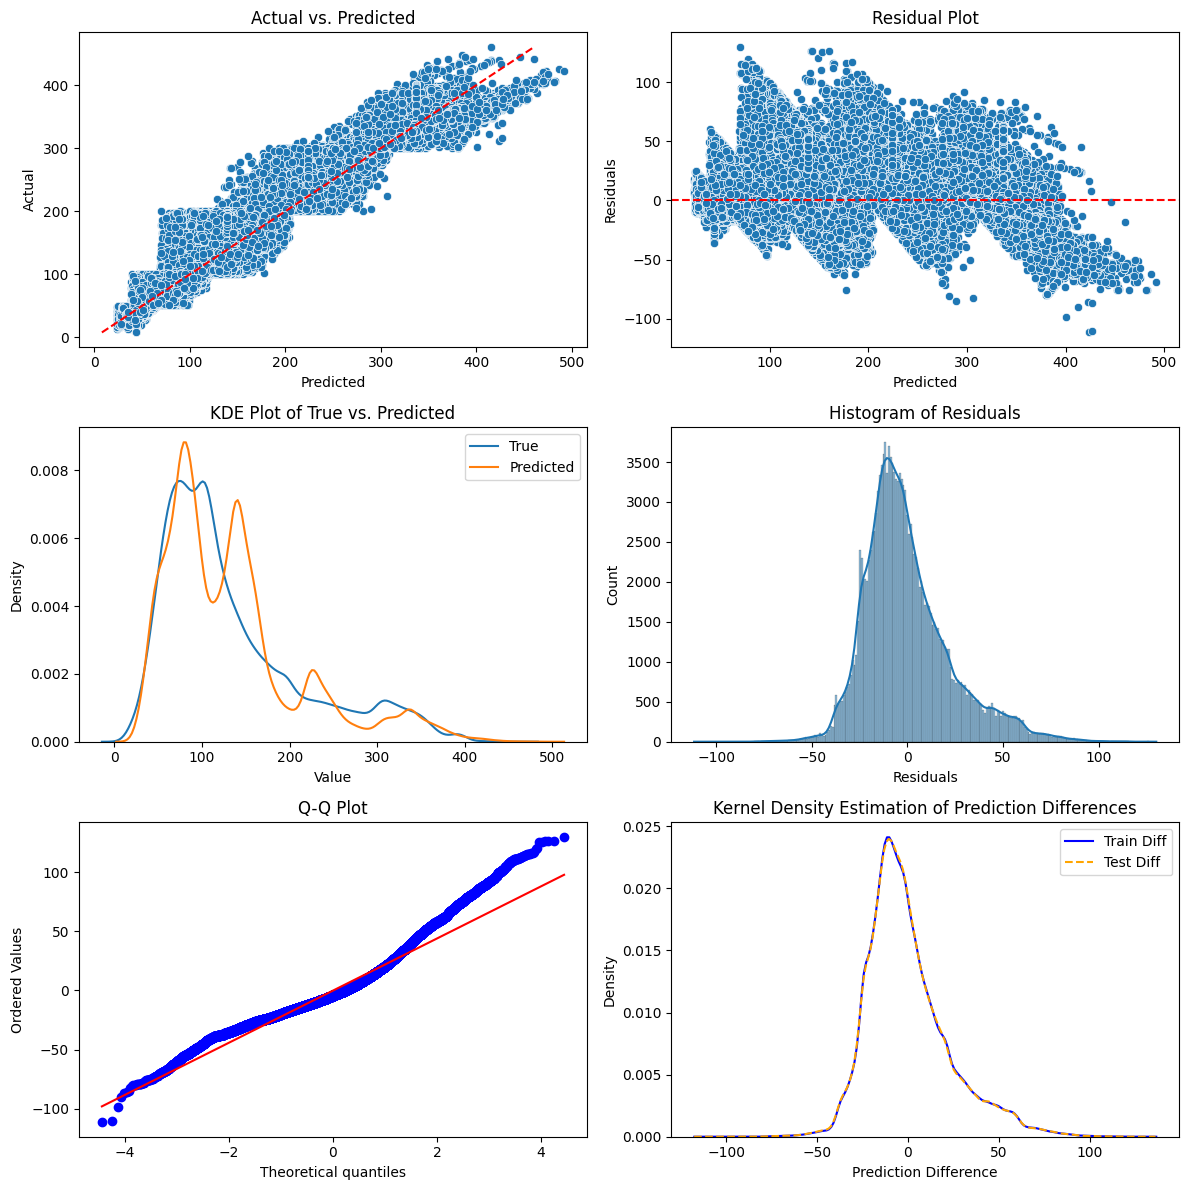

515.1559205114002
Training Score: 515.1511565560859
Testing Score: 514.2316464210388
Cross_Validation Score: [514.90056602 514.29773459 509.73801078 519.11871099 517.72458018]


In [258]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory=False)
model, train_score, test_score, cv_scores = preprocess_plot_score(df_filter, model= Lars(), scaler='ss', scale=True)
print("Training Score:", train_score)
print("Testing Score:", test_score)
print("Cross_Validation Score:", cv_scores)

In [259]:
df_filter = pd.read_csv('../data/clean_filtered_data.csv', low_memory = False)
X_train, X_test, y_train, y_test, scaler = df_split_scale(df_filter, scaler='ss', test_size=0.3, shuffle=True, scale=True)

In [260]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [261]:
def hyper_tune_regression_model(X_train, y_train, model_params, scoring='neg_mean_squared_error', cv=5, n_iter=30, random_state=None):
    model = model_params['model']
    param_grid = model_params['param_grid']
    # Instantiate RandomizedSearchCV
    random_search = RandomizedSearchCV(model,
                                       param_distributions=param_grid,
                                       n_iter=n_iter,
                                       cv=cv,
                                       scoring=scoring,
                                       random_state=random_state,
                                       n_jobs = -1)

    # Fit RandomizedSearchCV to the training data
    random_search.fit(X_train, y_train)

    # Get the best model, best parameters, and best score
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    # Print the scoring of the best model
    print(f"Best Score: {best_score:.4f}")

    return (best_model, best_params, best_score)


In [262]:
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

model_params = {
    'ElasticNet': {
        'model': ElasticNet(),
        'param_grid': {
            'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'fit_intercept': [True, False],
            'max_iter': [1000, 2000, 3000],
            'selection': ['cyclic', 'random']
        }
    },
    'SGDRegressor': {
        'model': SGDRegressor(),
        'param_grid': {
            'alpha': [0.0001, 0.001, 0.01],
            'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
            'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'max_iter': [1000, 2000, 3000],
            'tol': [1e-3, 1e-4, 1e-5]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [30, 40, 50],
            'p': [1, 2]
        }
    }
}

In [263]:
best_models = []
best_models.append(hyper_tune_regression_model(X_train, y_train, model_params['ElasticNet']))
best_models.append(hyper_tune_regression_model(X_train, y_train, model_params['SGDRegressor']))
best_models.append(hyper_tune_regression_model(X_train, y_train, model_params['KNeighborsRegressor']))

Best Score: -514.1520
Best Score: -514.1520
Best Score: -370.1266


In [264]:
best_models

[(ElasticNet(alpha=0.001, max_iter=2000, selection='random'),
  {'selection': 'random',
   'max_iter': 2000,
   'l1_ratio': 0.5,
   'fit_intercept': True,
   'alpha': 0.001},
  np.float64(-514.1519991671762)),
 (SGDRegressor(alpha=0.01, l1_ratio=0.25, learning_rate='adaptive', penalty='l1'),
  {'tol': 0.001,
   'penalty': 'l1',
   'max_iter': 1000,
   'learning_rate': 'adaptive',
   'l1_ratio': 0.25,
   'alpha': 0.01},
  np.float64(-514.1519767059567)),
 (KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9),
  {'weights': 'uniform',
   'p': 2,
   'n_neighbors': 9,
   'leaf_size': 30,
   'algorithm': 'kd_tree'},
  np.float64(-370.12660066549654))]

In [265]:
# Initialize lists to store results for each model
results = []

# Train and evaluate each model
for i, (best_model, _, _) in enumerate(best_models):
    # Train the model with best parameters
    best_model.fit(X_train, y_train)
    model_filename = f"model_no_{i + 1}.pkl"

    # Serialize the model to disk
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)

    # Make predictions on test data
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Calculate residuals
    residuals = y_test - y_pred_test

    # Calculate R^2 score
    # r2 = r2_score(y_test, y_pred)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred_test)

    # Store results for the current model
    results.append({
        'model': best_model,
        'y_true': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'residuals': residuals,
        # 'r2_score': r2,
        'mse': mse
    })

# Print test scores for each model
for i, result in enumerate(results):
    print(f"Model {i+1}:")
    # print(f"  R^2 Score: {result['r2_score']:.4f}")
    print(f"  Mean Squared Error: {result['mse']:.4f}")

Model 1:
  Mean Squared Error: 516.6130
Model 2:
  Mean Squared Error: 516.6121
Model 3:
  Mean Squared Error: 371.5782


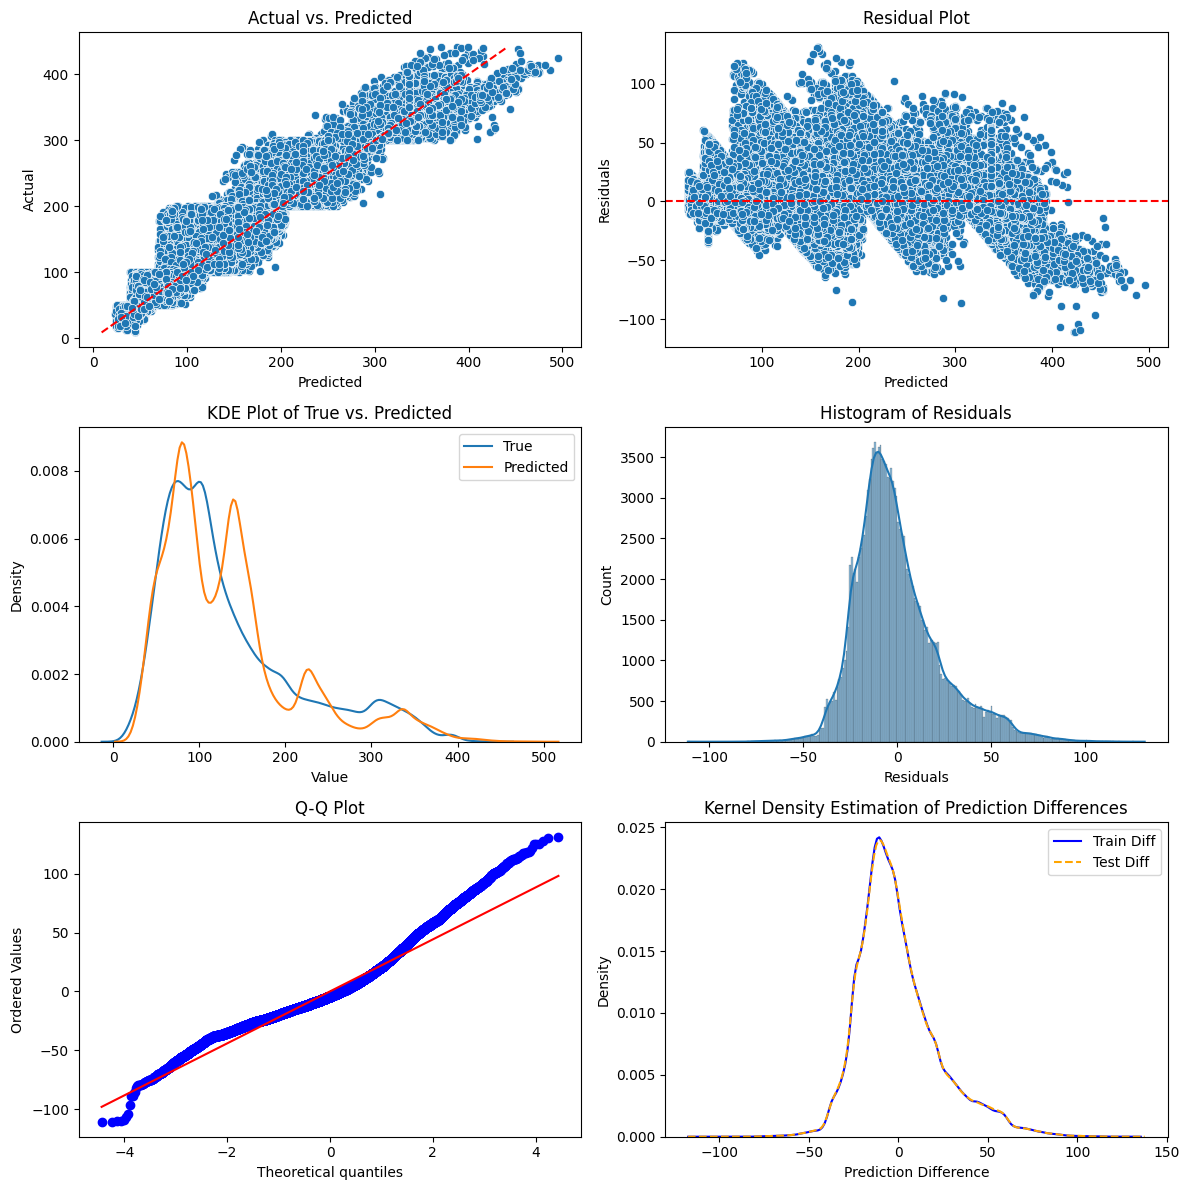

In [266]:
plot_regression_diagnostic_plots(y_train, results[0]['y_pred_train'], y_test, results[0]['y_pred_test'])

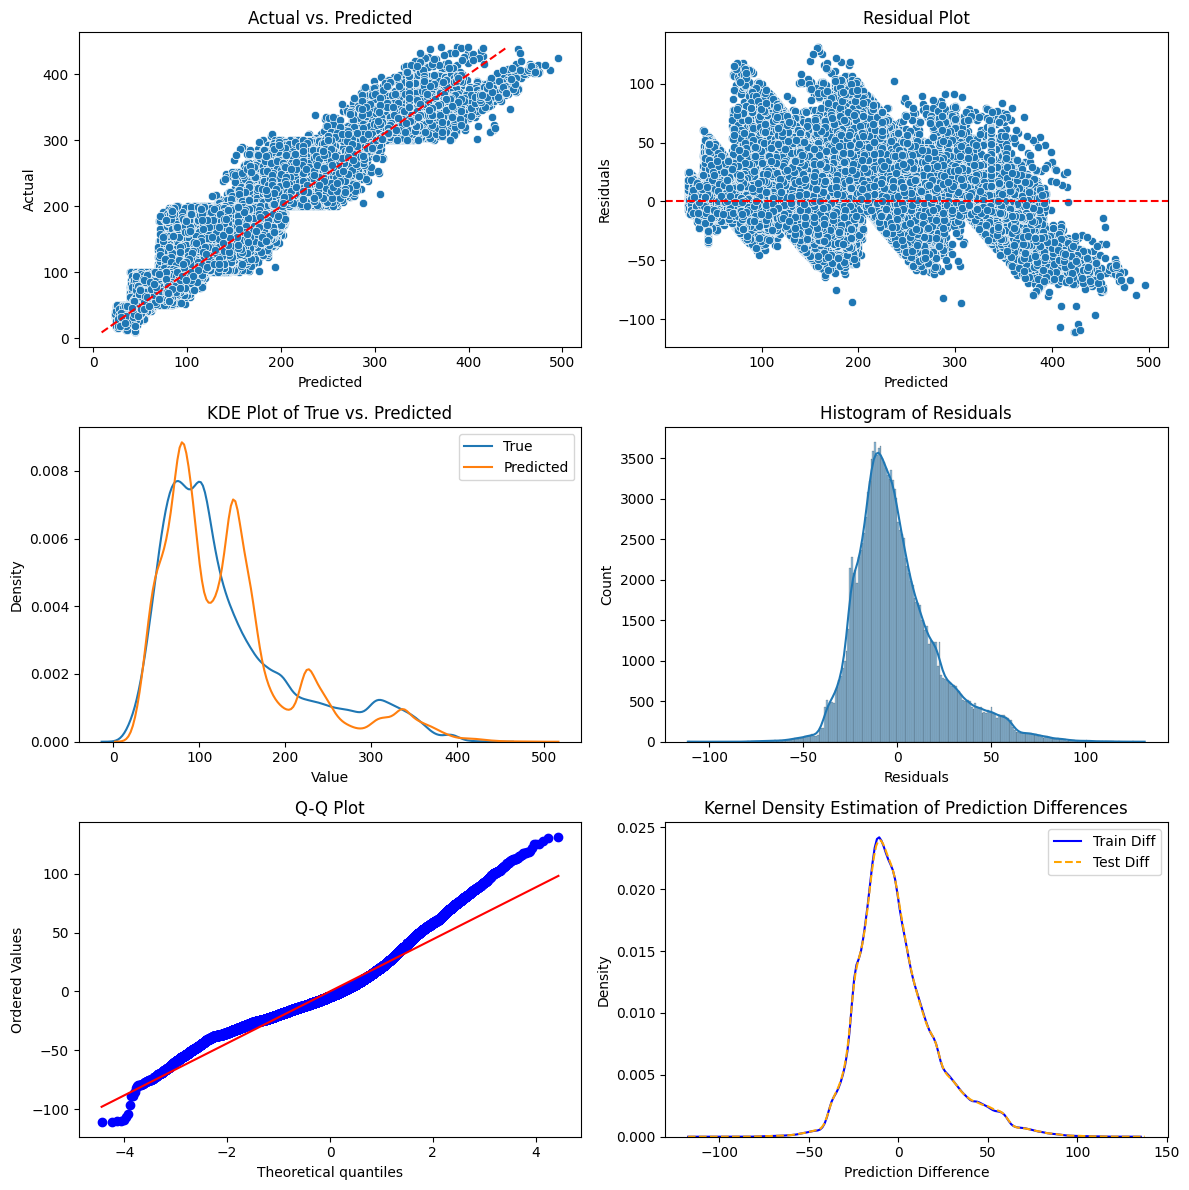

In [267]:
plot_regression_diagnostic_plots(y_train, results[1]['y_pred_train'], y_test, results[1]['y_pred_test'])

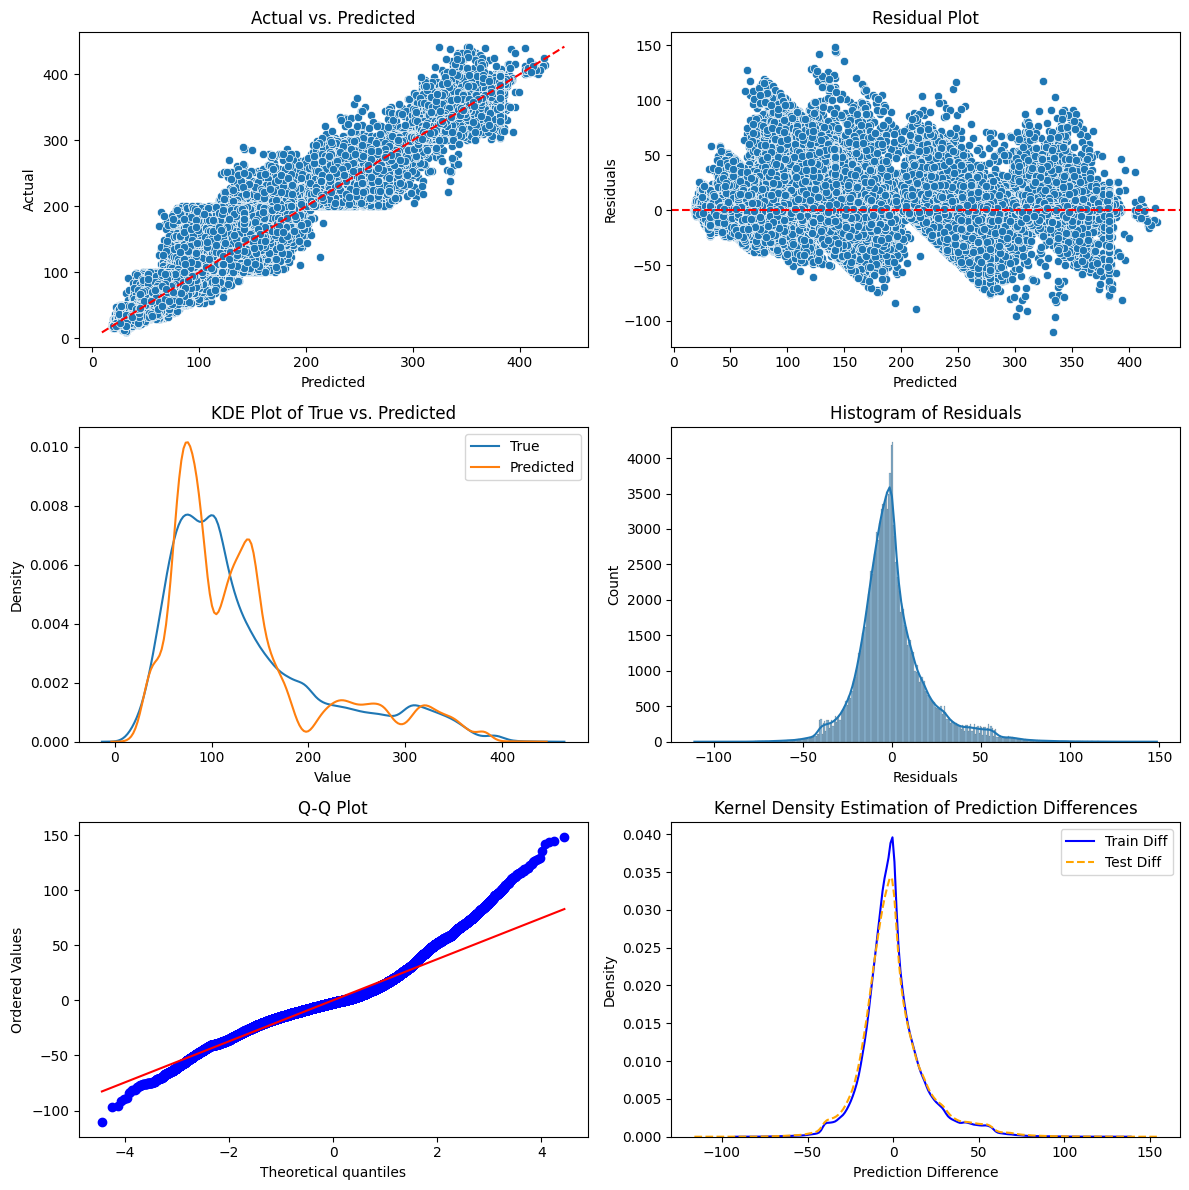

In [268]:
plot_regression_diagnostic_plots(y_train, results[2]['y_pred_train'], y_test, results[2]['y_pred_test'])

# Model Interpretation

In [269]:
# Train the Random Forest Regressor model
model = pickle.load(open('model_no_3.pkl', 'rb'))
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='kd_tree', n_neighbors=9)

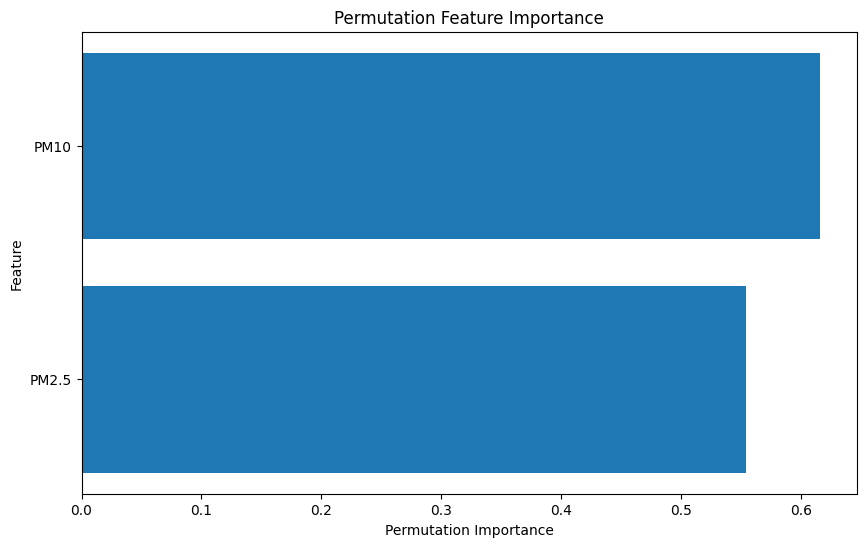

In [276]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Assuming model is already trained
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get the importances and corresponding standard deviations
importance = result.importances_mean
std = result.importances_std

# Feature names (you can replace them with your actual feature names)
feature_names = ['PM2.5', 'PM10']

# Sort the features based on their importance
sorted_indices = importance.argsort()
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.show()


In [ ]:
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train)